#匯入有用封包、模組與函式

In [0]:
from google.colab import drive

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, Reshape, Dropout
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import backend as K
import cv2

#GoogleDrive授權以便讀取檔案

In [30]:
# Google Drive授權，可直接讀取Drive內檔案
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
rootpath = '/content/gdrive/My Drive/IMBD_data2/'

# 創建資料夾以儲存結果

if not os.path.exists(rootpath+'Result'):
  os.mkdir(rootpath+'Result')
  print('Create: ',rootpath+'Result')
  
if not os.path.exists(rootpath+'Result/Bad_Curves_TrainingData'):
  os.mkdir(rootpath+'Result/Bad_Curves_TrainingData')
  print('Create: ',rootpath+'Result/Bad_Curves_TrainingData')
  
if not os.path.exists(rootpath+'Result/Model'):
  os.mkdir(rootpath+'Result/Model')
  print('Create: ',rootpath+'Result/Model')
  
if not os.path.exists(rootpath+'Result/Plot'):
  os.mkdir(rootpath+'Result/Plot')
  print('Create: ',rootpath+'Result/Plot')
  
if not os.path.exists(rootpath+'Result/Test_Prediction'):
  os.mkdir(rootpath+'Result/Test_Prediction')
  print('Create: ',rootpath+'Result/Test_Prediction')
  
if not os.path.exists(rootpath+'Result/Test_Wrong_Cat'):
  os.mkdir(rootpath+'Result/Test_Wrong_Cat')
  print('Create: ',rootpath+'Result/Test_Wrong_Cat')
  
if not os.path.exists(rootpath+'Result/VisualizationHeatMap_TrainTest'):
  os.mkdir(rootpath+'Result/VisualizationHeatMap_TrainTest')
  print('Create: ',rootpath+'Result/VisualizationHeatMap_TrainTest')
  
if not os.path.exists(rootpath+'Result/VisualizationHeatMap_TrueTest'):
  os.mkdir(rootpath+'Result/VisualizationHeatMap_TrueTest')
  print('Create: ',rootpath+'Result/VisualizationHeatMap_TrueTest')

In [32]:
# 進入google drive資料夾
os.chdir(rootpath)

# 秀出當前路徑內檔案，確認是否在正確的路徑下
os.listdir()

['Result', 'thubigdata2019exam-722', 'thubigdata2019training-230']

#初賽訓練數據

##讀取並整理初賽訓練數據

In [33]:
# 初賽訓練數據資料夾內子資料夾
ClassFolder = os.listdir(rootpath+'thubigdata2019training-230/大數據競賽初賽資料(230測試數據)')
print(ClassFolder)

['G17', 'G19', 'G32', 'G34', 'G48', 'G49', 'G15', 'G11']


In [34]:
# 利用迴圈將所有資料夾內檔案整合成一個dataframe
init_cnt = 0

for i in range(0,len(ClassFolder)):
  # 進入不同子資料夾以讀取檔案
  os.chdir(rootpath+'thubigdata2019training-230/大數據競賽初賽資料(230測試數據)/'+ClassFolder[i])  
  FileName_tmp = os.listdir()
  
  for j in range(0,len(FileName_tmp)):   
    data_tmp = pd.read_csv(FileName_tmp[j], sep='\\t', engine='python')
    data_tmp = data_tmp.transpose()   
    data_tmp = data_tmp.drop([0],axis=1) #丟掉溫度單位(Deg.F)
    data_tmp = data_tmp.astype(float) #將string轉換成float    
    data_tmp.insert(0,'Type',FileName_tmp[j][0:3])
    data_tmp.insert(0,'FileName',FileName_tmp[j])      
  
    if init_cnt == 0:
      data = data_tmp
      init_cnt += 1
    else:
      data = data.append(data_tmp,sort=False) 
    
data = data.reset_index()
data = data.rename(columns={"index":"Col"})
    
print(data.head())
print(data.shape)

           Col                             FileName Type  ...  447  448  449
0   G17-PTC7    G17-AC(7X15)20170327-001_Export.txt  G17  ...  NaN  NaN  NaN
1   G17-PTC9    G17-AC(7X15)20170327-001_Export.txt  G17  ...  NaN  NaN  NaN
2  G17-PTC10    G17-AC(7X15)20170327-001_Export.txt  G17  ...  NaN  NaN  NaN
3  G17-PTC11    G17-AC(7X15)20170327-001_Export.txt  G17  ...  NaN  NaN  NaN
4  G17-PTC12    G17-AC(7X15)20170327-001_Export.txt  G17  ...  NaN  NaN  NaN

[5 rows x 452 columns]
(1745, 452)


##初賽訓練數據的設置分配與前處理

###對時間溫度曲線數據進行微分

In [0]:
m, n = data.shape
x_tmp1 = data.iloc[:,3:n].values.copy()
x_tmp2 = data.iloc[:,3:n].values.copy()
data_diff = data.copy()

for i in range(0,m):
  f = x_tmp1[i,0:n]

  ind = np.isnan(f)
  f[np.isnan(f)] = f[f.shape[0]-ind.sum()-1]

  fg = np.gradient(f)

  x_tmp1[i,0:n] = f
  x_tmp2[i,0:n] = fg

data.iloc[:,3:n] = x_tmp1
data_diff.iloc[:,3:n] = x_tmp2

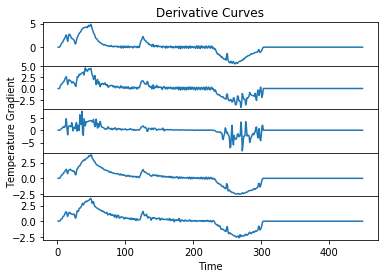

In [36]:
# 畫出train前5個微分的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_diff.iloc[i,3:n])

    if i == 0:
      plt.title('Derivative Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature Gradient')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/derivative_curves.jpg'
figure.savefig(output_file)

###將不穩定的時間溫度曲線剔除，以免影響模型表現。

In [0]:
# 對微分數值設閾值，篩選不穩定之時間溫度曲線
ind_bad = []
m, n = data_diff.shape

for i in range(0,m):
  tmp = data_diff.iloc[i,3:n].values.copy()
  
  if abs(tmp.min())>15 or abs(tmp.max())>15:
    ind_bad = ind_bad + [i]

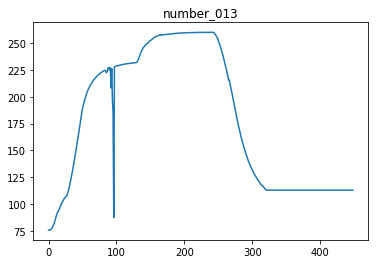

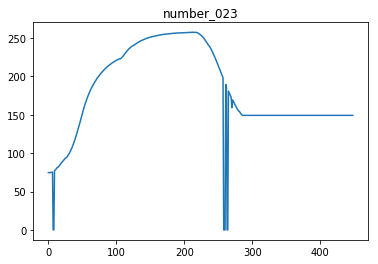

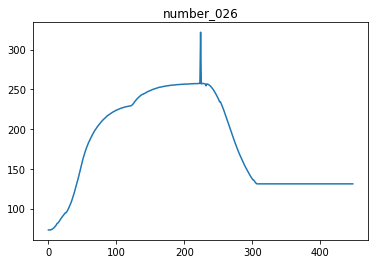

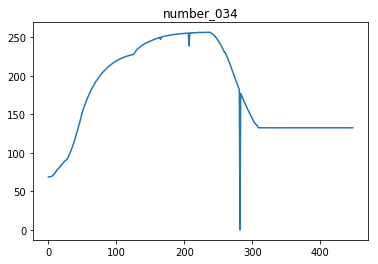

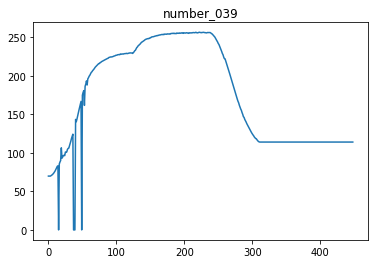

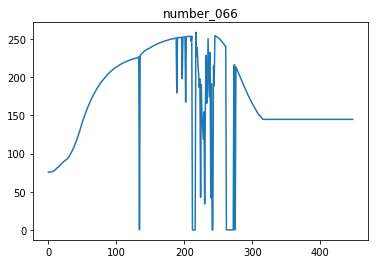

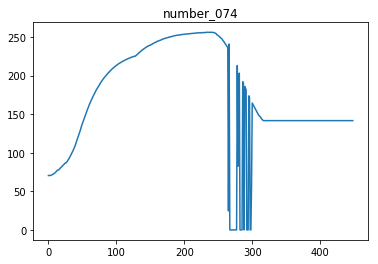

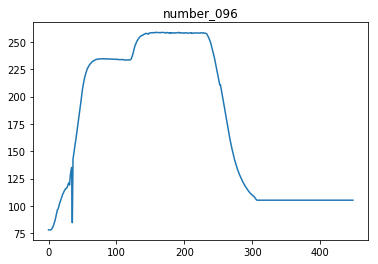

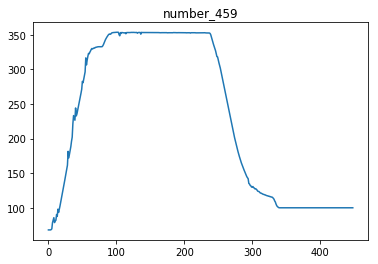

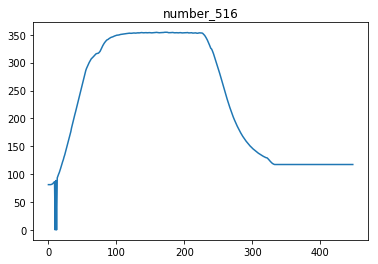

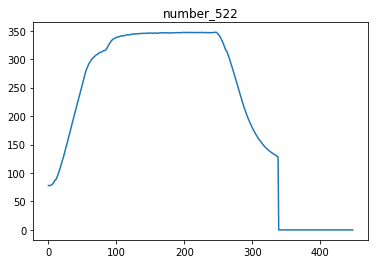

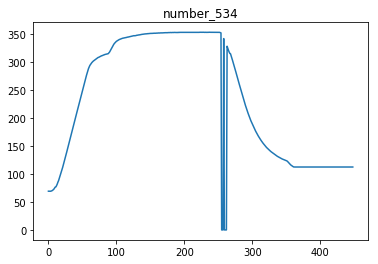

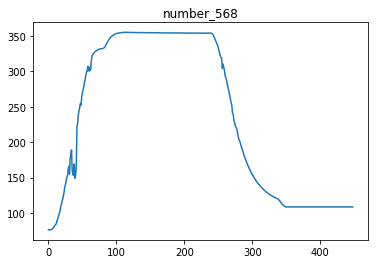

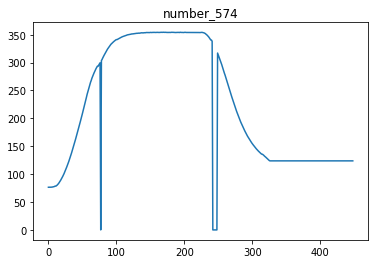

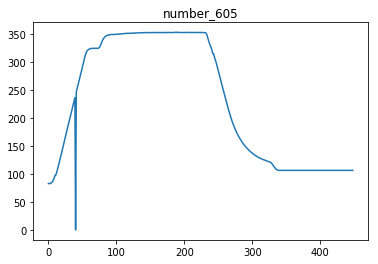

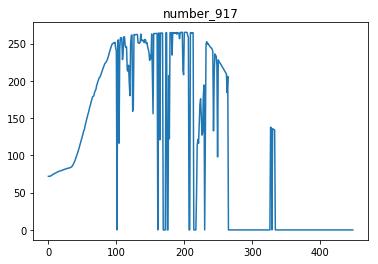

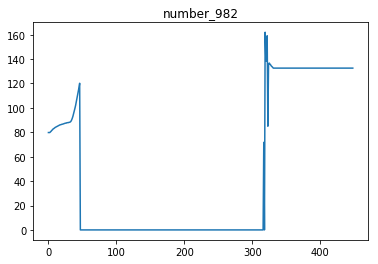

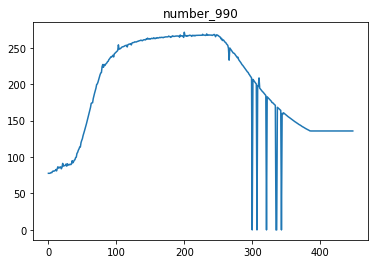

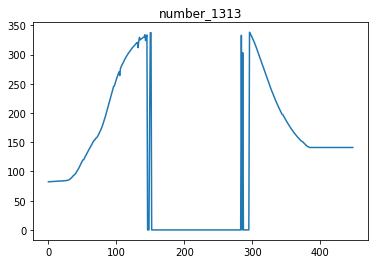

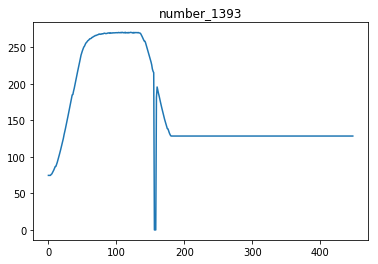

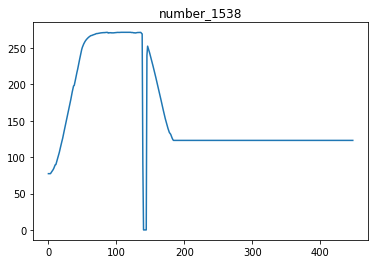

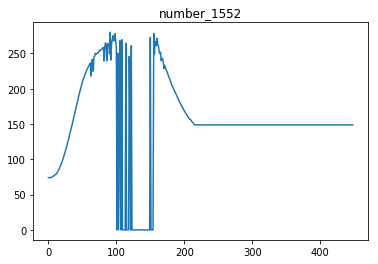

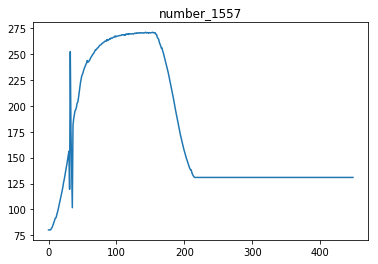

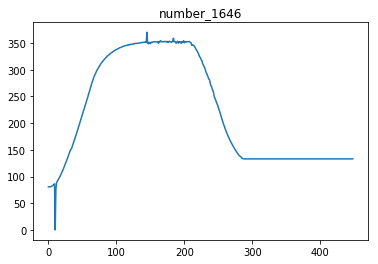

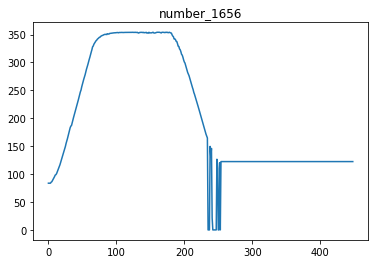

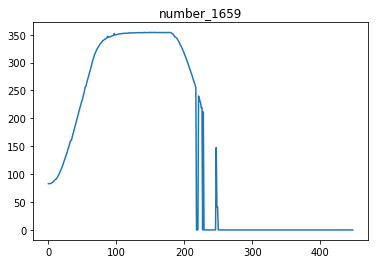

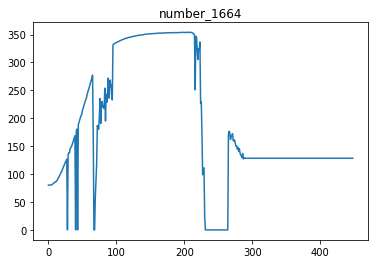

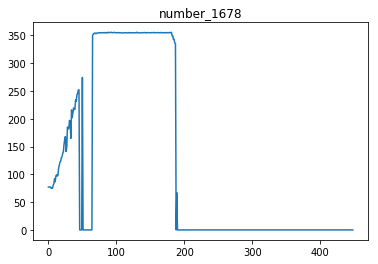

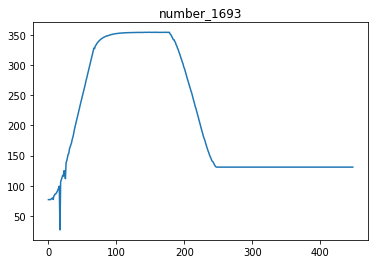

In [38]:
# 繪製不穩定之時間溫度曲線
m, n = data.shape

for i in ind_bad:
  str_1 = str(i).zfill(3);
  
  plt.plot(data.iloc[i,3:n].values)
  plt.title('number_'+str_1)
  output_file = rootpath+'Result/Bad_Curves_TrainingData/'+str_1+'.jpg'
  plt.savefig(output_file)
  
  plt.figure
  plt.show()

In [39]:
# 將品質壞掉的時間溫度曲線拿掉
data_fin = data.drop(data.index[ind_bad])
data_diff_fin = data_diff.drop(data_diff.index[ind_bad])

print('Original shape:',data.shape)
print('Final shape:',data_fin.shape)

Original shape: (1745, 452)
Final shape: (1716, 452)


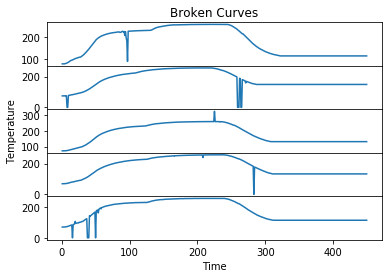

In [40]:
# 畫出前5個壞掉的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data.iloc[ind_bad[i],3:data.shape[1]])
    
    if i == 0:
      plt.title('Broken Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/broken_curves.jpg'
figure.savefig(output_file)

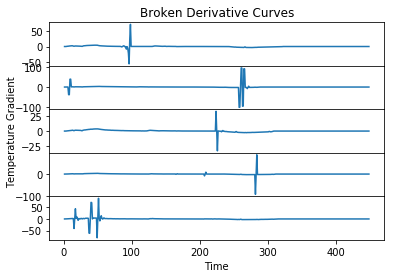

In [41]:
# 畫出前5個壞掉的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_diff.iloc[ind_bad[i],3:data.shape[1]])
    
    if i == 0:
      plt.title('Broken Derivative Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature Gradient')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/broken_derivative_curves.jpg'
figure.savefig(output_file)

###將初賽訓練數據分配成90%訓練與10%測試，以評估模型。

In [42]:
# 隨機分配數據為90%訓練和10%測試
fun_1 = lambda x: x.sample(frac=0.9, replace=False, random_state=1)

data_fin_Train = data_diff_fin.groupby('Type', group_keys=False).apply(fun_1)
data_fin_Test = data_diff_fin.drop(data_fin_Train.index)

print('Train shape:',data_fin_Train.shape)
print('Test shape:',data_fin_Test.shape)

Train shape: (1545, 452)
Test shape: (171, 452)


In [43]:
# 檢查在Train和Test資料分布比例是否一致
type_counts_Train = data_fin_Train.groupby('Type', group_keys=False).count()
type_counts_Train = type_counts_Train['Col']
type_counts_Train = type_counts_Train/type_counts_Train.sum()*100
type_counts_Train.index.name = "Type (%)"

type_counts_Test = data_fin_Test.groupby('Type', group_keys=False).count()
type_counts_Test = type_counts_Test['Col']
type_counts_Test = type_counts_Test/type_counts_Test.sum()*100
type_counts_Test.index.name = "Type (%)"

print('Train: ',type_counts_Train)
print('Test: ',type_counts_Test)

Train:  Type (%)
G11     8.090615
G15    11.844660
G17     6.472492
G19    13.851133
G32    14.498382
G34    15.404531
G48    14.045307
G49    15.792880
Name: Col, dtype: float64
Test:  Type (%)
G11     8.187135
G15    11.695906
G17     6.432749
G19    14.035088
G32    14.619883
G34    15.204678
G48    14.035088
G49    15.789474
Name: Col, dtype: float64


In [0]:
# 設置x和y
x_all_train = data_fin_Train.drop(['Col','FileName','Type'],axis=1)
x_all_test = data_fin_Test.drop(['Col','FileName','Type'],axis=1)

# 將y做成one-hot encoding
# 要注意不同模型訓練的時候丟入的y有可能是原本0和1(y_train)，或是經過one-hot encoding的(y_dummy)
y_all_train = data_fin_Train['Type']
y_all_dummy_train = pd.get_dummies(y_all_train)
y_all_test = data_fin_Test['Type']
y_all_dummy_test = pd.get_dummies(y_all_test)


In [45]:
# 檢視設置結果
print('train:')
print('x:',x_all_train.shape)
print(x_all_train.head(3))
print('y:',y_all_dummy_train.shape)
print(y_all_dummy_train.head(3))
print()
print('test:')
print('x:',x_all_test.shape)
print(x_all_test.head(3))
print('y:',y_all_dummy_test.shape)
print(y_all_dummy_test.head(3))

train:
x: (1545, 449)
      1    2     3     4     5     6    7    ...  443  444  445  446  447  448  449
1669  0.0  0.0  0.00  0.45  0.90  0.95  1.3  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1661  0.0  0.0  0.00  0.55  1.20  1.50  2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1642  0.0  0.0  0.05  0.20  0.45  0.70  0.9  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[3 rows x 449 columns]
y: (1545, 8)
      G11  G15  G17  G19  G32  G34  G48  G49
1669    1    0    0    0    0    0    0    0
1661    1    0    0    0    0    0    0    0
1642    1    0    0    0    0    0    0    0

test:
x: (171, 449)
   1    2    3     4     5     6     7    ...  443  444  445  446  447  448  449
1  0.0  0.0  0.0  0.50  0.85  0.90  1.15  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.05  0.10  0.15  0.30  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9  0.0  0.0  0.0  0.45  0.65  0.80  1.10  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[3 rows x 449 columns]
y: (171, 8)
   G11  G15  G17  G19  G32  G34  G48  G49
1 

##訓練模型建構

In [0]:
# 建構訓練模型函式以便單獨與cross-validation使用

def evaluate_model(X_train, y_train, save_model_str, *args):
  
  # 建構1D-CNN的模型
  model = Sequential()
  # 將模型reshape成(時間長度,1)，每筆輸入的曲線為(時間長度,)的大小
  model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
  model.add(Conv1D(100, 10, activation='relu', input_shape=(X_train.shape[1], 1)))
  model.add(Conv1D(100, 10, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(Conv1D(160, 10, activation='relu'))
  model.add(Conv1D(160, 10, activation='relu'))
  model.add(GlobalAveragePooling1D())
  #model.add(Dropout(0.5))
  model.add(Dense(y_train.shape[1], activation='softmax'))
  
  # compile此模型以便開始訓練
  model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])
  
  if save_model_str == 'model_CV.h5':
    X_val = args[0]
    y_val = args[1]
    
    # 進入結果資料夾
    os.chdir(rootpath+'Result/Model')
    model.save_weights(save_model_str) #儲存未訓練參數，以便cross-validation重新訓練時重置
  
    random.seed (21)
    history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=50, batch_size=100, verbose=2)

    _, val_acc = model.evaluate(X_val, y_val, verbose = 1)  
    model.load_weights(save_model_str) #讀取未訓練參數，以便cross-validation重新訓練時重置
  
  else:   
    random.seed (21)
    history = model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=2)
    
    # 進入結果資料夾
    os.chdir(rootpath+'Result/Model')
    model.save_weights(save_model_str) #將訓練好的模型儲存
    
    _, val_acc = model.evaluate(X_train, y_train, verbose = 1) 
  
  return model, val_acc, history

###5-fold交叉驗證訓練評估模型穩定度

In [47]:
# 開始進行cross-validation

n_folds = 5
cv_scores, model_history, train_history = list(), list(), list()

for _ in range(n_folds):
  # split data
  X_train, X_val, y_train, y_val = \
      train_test_split(x_all_train, y_all_dummy_train, test_size=1/n_folds, \
      random_state = np.random.randint(1,1000, 1)[0], stratify=y_all_dummy_train)
  
  # evaluate model
  model, val_acc, history = evaluate_model(X_train, y_train, 'model_CV.h5', X_val, y_val)
  print('>%.3f' % val_acc)
  
  cv_scores.append(val_acc)
  model_history.append(model)
  train_history.append(history)

Train on 1236 samples, validate on 309 samples
Epoch 1/50
 - 1s - loss: 1.8961 - acc: 0.1998 - val_loss: 1.5818 - val_acc: 0.3398
Epoch 2/50
 - 0s - loss: 1.2243 - acc: 0.5518 - val_loss: 0.7802 - val_acc: 0.7282
Epoch 3/50
 - 0s - loss: 0.7051 - acc: 0.6934 - val_loss: 0.4937 - val_acc: 0.8123
Epoch 4/50
 - 0s - loss: 0.4556 - acc: 0.8479 - val_loss: 0.2539 - val_acc: 0.9450
Epoch 5/50
 - 0s - loss: 0.2341 - acc: 0.9353 - val_loss: 0.1555 - val_acc: 0.9515
Epoch 6/50
 - 0s - loss: 0.1201 - acc: 0.9636 - val_loss: 0.1626 - val_acc: 0.9547
Epoch 7/50
 - 0s - loss: 0.1254 - acc: 0.9652 - val_loss: 0.1101 - val_acc: 0.9676
Epoch 8/50
 - 0s - loss: 0.0987 - acc: 0.9717 - val_loss: 0.0510 - val_acc: 0.9871
Epoch 9/50
 - 0s - loss: 0.0599 - acc: 0.9822 - val_loss: 0.0501 - val_acc: 0.9903
Epoch 10/50
 - 0s - loss: 0.0472 - acc: 0.9846 - val_loss: 0.0681 - val_acc: 0.9806
Epoch 11/50
 - 0s - loss: 0.0626 - acc: 0.9806 - val_loss: 0.0445 - val_acc: 0.9903
Epoch 12/50
 - 0s - loss: 0.0470 - acc

In [48]:
#交叉驗證準確度的平均(標準差)
print(cv_scores)
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

[1.0, 0.9935275080906149, 0.9935275082835102, 0.9935275080906149, 1.0]
Estimated Accuracy 0.996 (0.003)


###檢視交叉驗證訓練過程

In [0]:
def show_train_history(train_history,train,validation):
  subplots_adjust(hspace=0.000)
  number_of_subplots=len(train_history)
  
  for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(train_history[i].history[train])
    ax1.plot(train_history[i].history[validation])
    
    if i == 0:
      plt.title('Train History')
    elif i == round(number_of_subplots/2):
      plt.ylabel(train)
    elif i == number_of_subplots-1:
      plt.xlabel('Epoch')  
      plt.legend(['train', 'validation'], loc='upper right') 

  plt.show()
  
  figure=ax1.get_figure()
  output_file = rootpath+'Result/Plot/cv_training_history_'+train+'.jpg'
  figure.savefig(output_file)

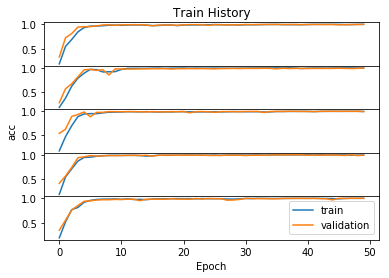

In [50]:
# 準確度
show_train_history(train_history,'acc','val_acc')

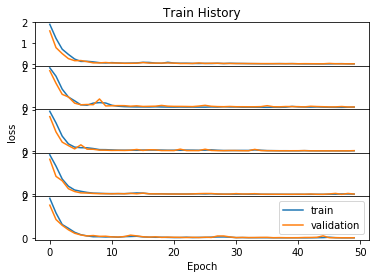

In [51]:
# Loss
show_train_history(train_history,'loss','val_loss')

###使用所有90%訓練數據建構模型

In [52]:
# 訓練90%訓練數據，建構模型
model, val_acc, history = evaluate_model(x_all_train, y_all_dummy_train, 'model_CV_fin.h5')
print('>%.3f' % val_acc)

Epoch 1/50
 - 1s - loss: 1.8960 - acc: 0.2123
Epoch 2/50
 - 0s - loss: 1.2078 - acc: 0.4803
Epoch 3/50
 - 0s - loss: 0.7053 - acc: 0.7379
Epoch 4/50
 - 0s - loss: 0.3490 - acc: 0.9010
Epoch 5/50
 - 0s - loss: 0.1843 - acc: 0.9463
Epoch 6/50
 - 0s - loss: 0.1014 - acc: 0.9722
Epoch 7/50
 - 0s - loss: 0.0561 - acc: 0.9819
Epoch 8/50
 - 0s - loss: 0.0504 - acc: 0.9864
Epoch 9/50
 - 0s - loss: 0.0542 - acc: 0.9819
Epoch 10/50
 - 0s - loss: 0.0378 - acc: 0.9877
Epoch 11/50
 - 0s - loss: 0.0382 - acc: 0.9883
Epoch 12/50
 - 0s - loss: 0.0420 - acc: 0.9890
Epoch 13/50
 - 0s - loss: 0.0454 - acc: 0.9871
Epoch 14/50
 - 0s - loss: 0.0306 - acc: 0.9916
Epoch 15/50
 - 0s - loss: 0.0317 - acc: 0.9890
Epoch 16/50
 - 0s - loss: 0.0431 - acc: 0.9851
Epoch 17/50
 - 0s - loss: 0.0375 - acc: 0.9883
Epoch 18/50
 - 0s - loss: 0.0395 - acc: 0.9845
Epoch 19/50
 - 0s - loss: 0.0195 - acc: 0.9935
Epoch 20/50
 - 0s - loss: 0.0152 - acc: 0.9935
Epoch 21/50
 - 0s - loss: 0.0155 - acc: 0.9929
Epoch 22/50
 - 0s - lo

In [53]:
# 預測訓練模型並檢視結果
y_probs_train = model.predict_proba(x_all_train) #利用訓練後模型預測train資料的結果
print(y_probs_train.shape) #矩陣大小
print(y_probs_train[0:4,:]) #只顯示前五列

(1545, 8)
[[9.9959773e-01 4.0187317e-04 1.7330159e-07 1.6214158e-18 2.3302003e-07
  2.8616886e-24 1.3443137e-18 1.9272224e-16]
 [9.9991095e-01 5.3776574e-05 2.4269160e-09 7.8456127e-22 3.5286983e-05
  1.2218398e-23 5.2645083e-20 7.4619817e-16]
 [9.9992323e-01 2.4119297e-05 7.8033217e-08 3.3572746e-19 5.2516105e-05
  6.3359774e-23 4.3055714e-17 4.2454744e-15]
 [9.9997473e-01 1.4221446e-05 8.4178025e-09 2.7938437e-21 1.1065422e-05
  2.9733704e-23 3.1291746e-19 2.1929785e-15]]


In [54]:
# 數字轉換分類結果
ind = np.argmax(y_probs_train,1)
y_prdict = data_fin.Type.astype('category')
y_prdict = y_prdict.dtypes.categories 
y_prdict = y_prdict[ind]
y_prdict = pd.Series(y_prdict)

# 訓練與驗證數據，訓練準確度
accuracy = accuracy_score(y_all_train, y_prdict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


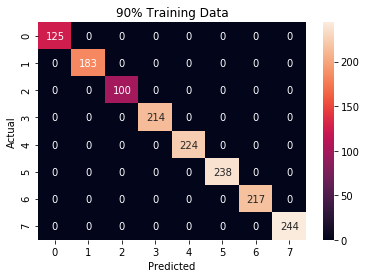

In [55]:
# 畫出confusion matrix
cm = confusion_matrix(y_all_train,y_prdict)
ax = sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual', title='90% Training Data')
np.shape(y_all_train)

figure = ax.get_figure()    
output_file = rootpath+'Result/Plot/train_confusion_matrix.jpg'
figure.savefig(output_file)

###10%測試數據的預測與評估

In [56]:
y_probs_test = model.predict_proba(x_all_test) 
print(y_probs_test.shape) #矩陣大小
print(y_probs_test[0:4,:]) #只顯示前五列

(171, 8)
[[1.14382196e-07 6.93072116e-06 9.99991775e-01 7.35340559e-20
  2.92803719e-08 6.87151334e-12 1.75092048e-08 1.10207088e-06]
 [8.68118732e-05 4.08498017e-05 9.99792516e-01 7.33388231e-14
  3.79426092e-06 2.60257397e-12 6.54436662e-05 1.06540720e-05]
 [6.49623928e-08 5.25360747e-07 9.99988794e-01 6.55236824e-21
  6.75920759e-08 4.10226367e-12 1.97551387e-07 1.02873455e-05]
 [2.97090533e-04 7.84620897e-06 9.98799682e-01 1.06056394e-14
  2.93022968e-05 2.06078314e-11 7.61062489e-04 1.05038685e-04]]


In [57]:
# 數字轉換分類結果
ind = np.argmax(y_probs_test,1)
y_prdict_test = data_fin.Type.astype('category')
y_prdict_test = y_prdict_test.dtypes.categories 
y_prdict_test = y_prdict_test[ind]
y_prdict_test = pd.Series(y_prdict_test)

# 測試數據，預測準確度
# evaluate predictions
accuracy = accuracy_score(y_all_test, y_prdict_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


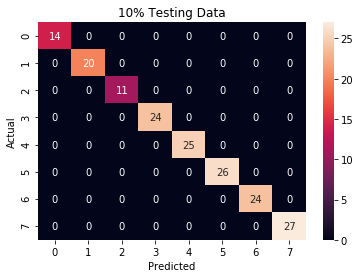

In [58]:
# 畫出confusion matrix
cm = confusion_matrix(y_all_test,y_prdict_test)
ax = sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual', title='10% Testing Data')
np.shape(y_all_test)

figure = ax.get_figure()    
output_file = rootpath+'Result/Plot/test_confusion_matrix.jpg'
figure.savefig(output_file)

###分類依據可視化分析

透過可視化分析，能夠知道模型是針對哪些時間段，對時間溫度曲線進行分類，在熱力圖中，會依照藍到紅顯示，越紅表示越重要。

000
Test data number:  0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 449, 1)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 440, 100)          1100      
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 431, 100)          100100    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 143, 100)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 134, 160)          160160    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 125, 160)          256160    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 160)           

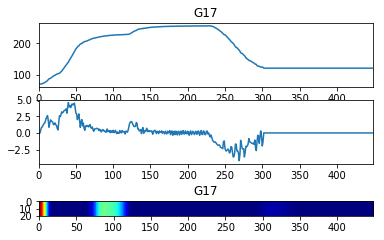

001
Test data number:  1


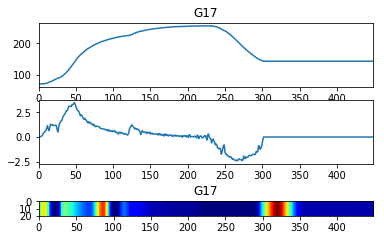

002
Test data number:  2


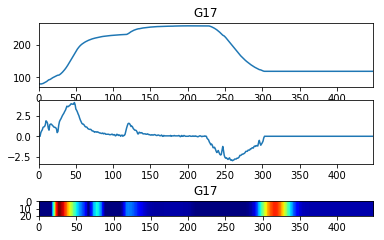

003
Test data number:  3


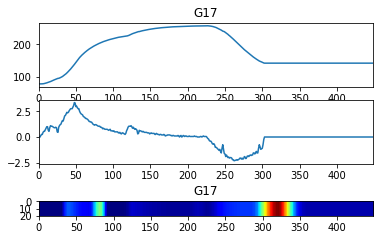

004
Test data number:  4


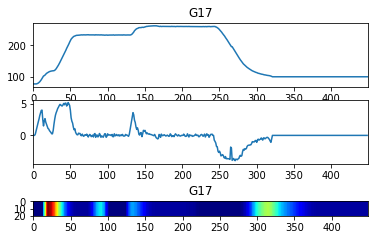

005
Test data number:  5


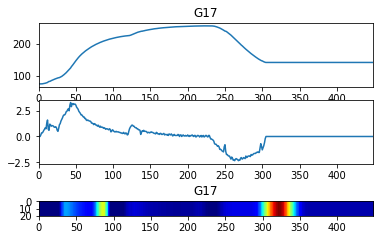

006
Test data number:  6


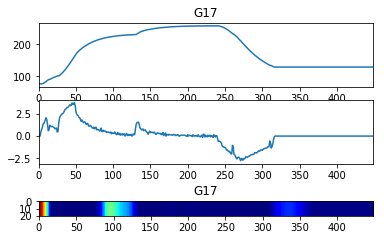

007
Test data number:  7


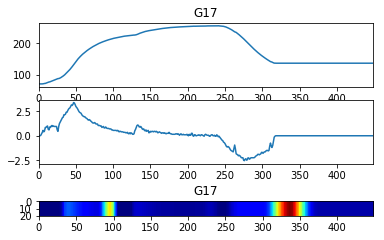

008
Test data number:  8


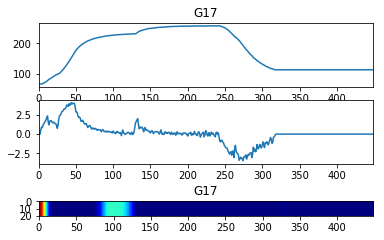

009
Test data number:  9


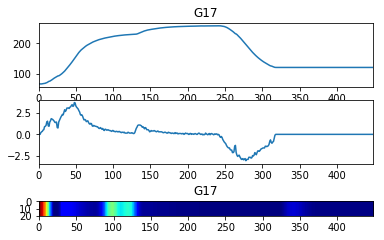

010
Test data number:  10


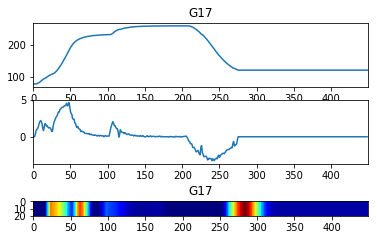

011
Test data number:  11


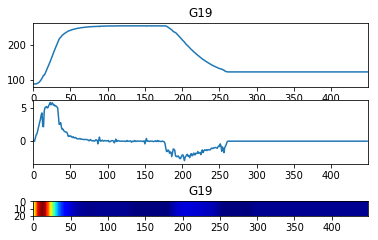

012
Test data number:  12


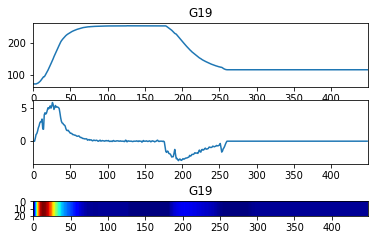

013
Test data number:  13


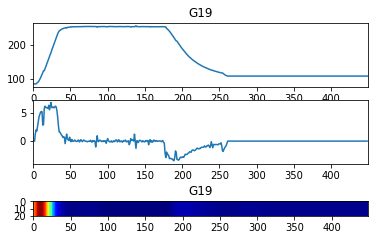

014
Test data number:  14


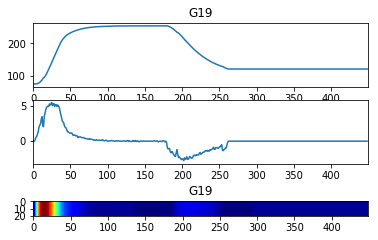

015
Test data number:  15


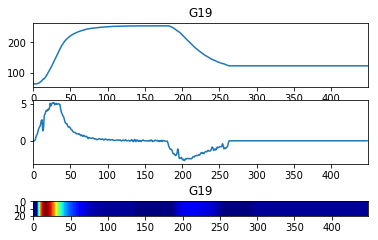

016
Test data number:  16


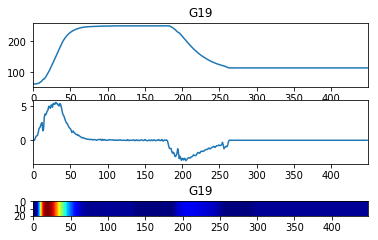

017
Test data number:  17


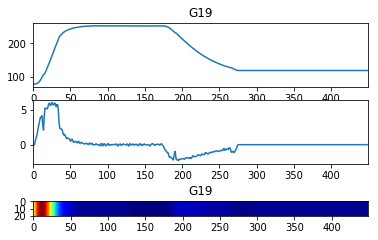

018
Test data number:  18


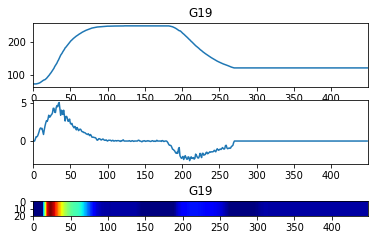

019
Test data number:  19


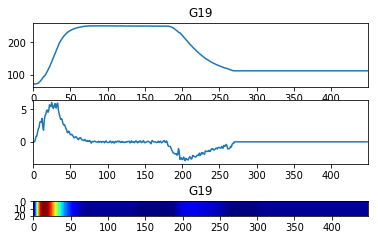

020
Test data number:  20


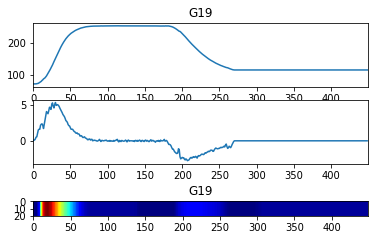

021
Test data number:  21


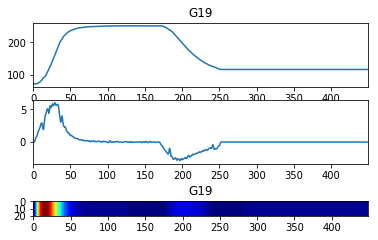

022
Test data number:  22


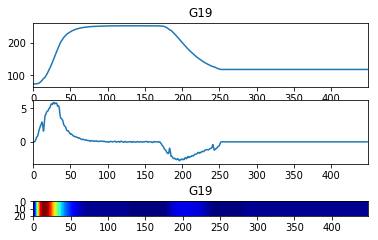

023
Test data number:  23


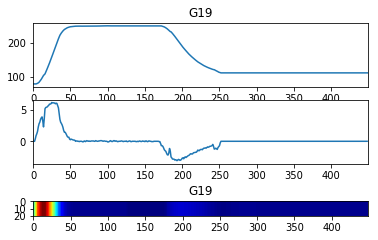

024
Test data number:  24


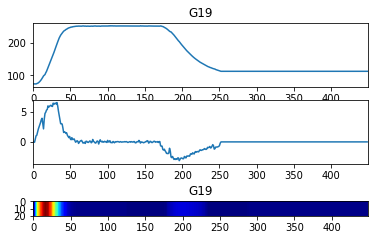

025
Test data number:  25


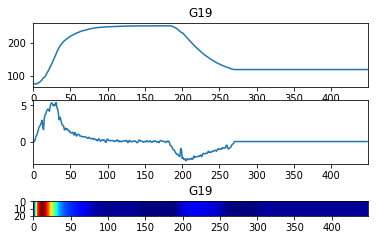

026
Test data number:  26


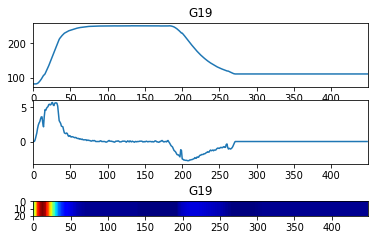

027
Test data number:  27


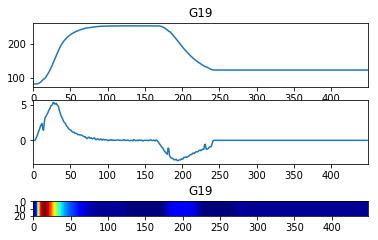

028
Test data number:  28


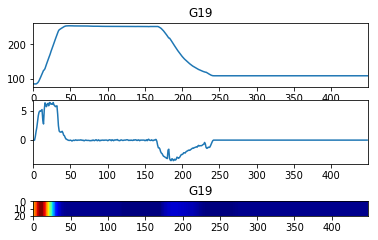

029
Test data number:  29


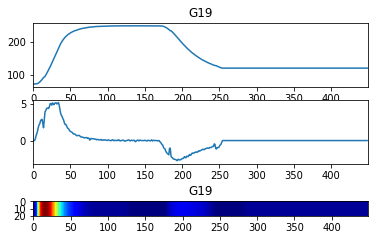

030
Test data number:  30


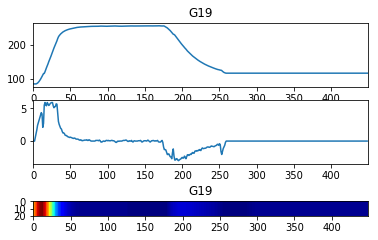

031
Test data number:  31


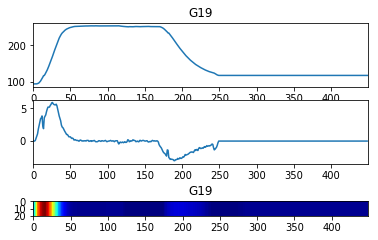

032
Test data number:  32


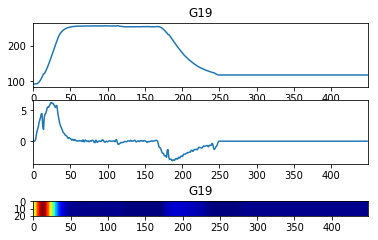

033
Test data number:  33


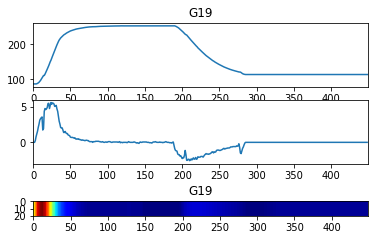

034
Test data number:  34


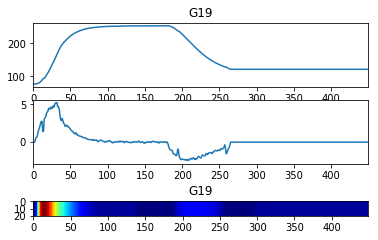

035
Test data number:  35


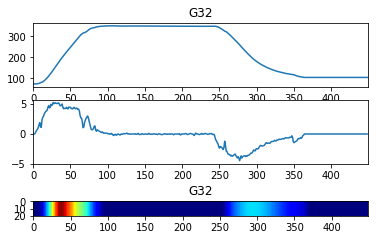

036
Test data number:  36


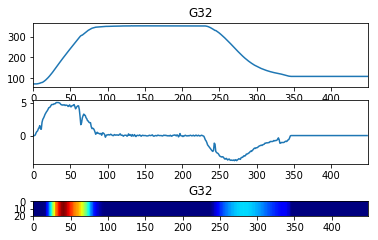

037
Test data number:  37


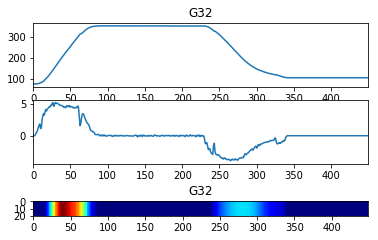

038
Test data number:  38


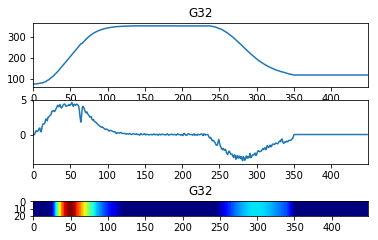

039
Test data number:  39


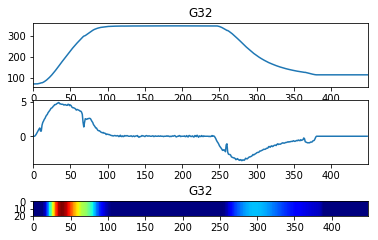

040
Test data number:  40


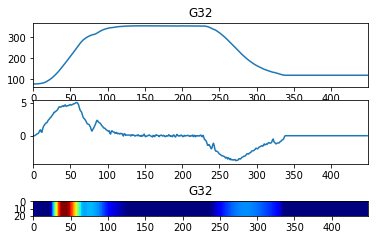

041
Test data number:  41


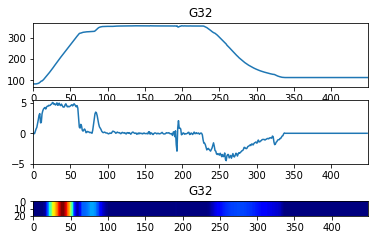

042
Test data number:  42


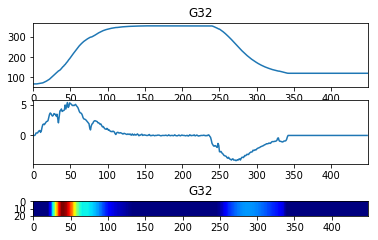

043
Test data number:  43


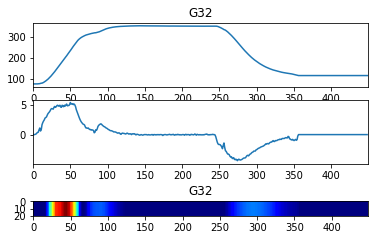

044
Test data number:  44


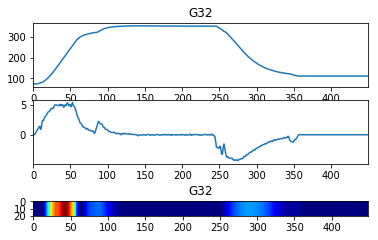

045
Test data number:  45


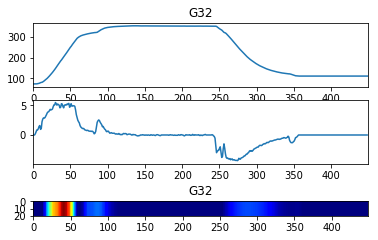

046
Test data number:  46


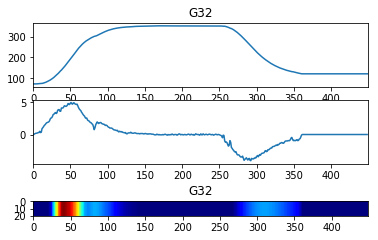

047
Test data number:  47


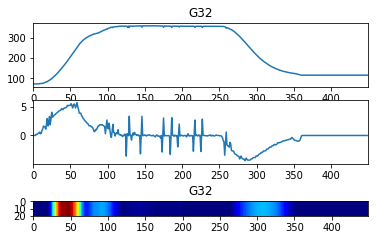

048
Test data number:  48


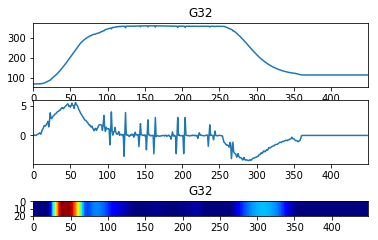

049
Test data number:  49


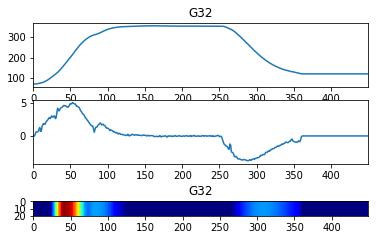

050
Test data number:  50


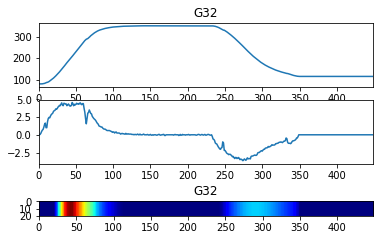

051
Test data number:  51


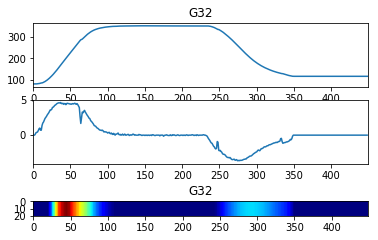

052
Test data number:  52


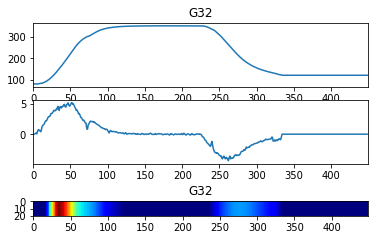

053
Test data number:  53


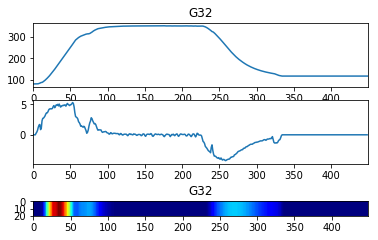

054
Test data number:  54


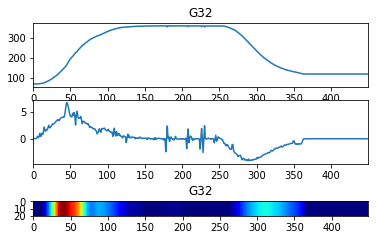

055
Test data number:  55


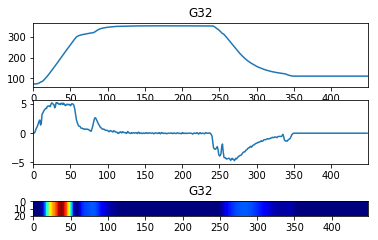

056
Test data number:  56


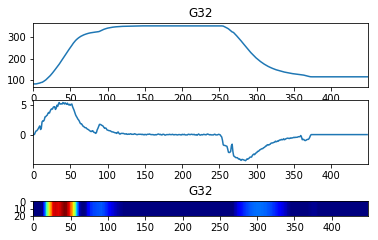

057
Test data number:  57


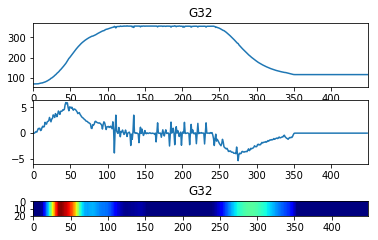

058
Test data number:  58


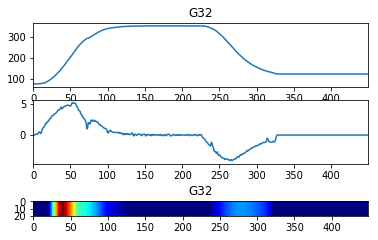

059
Test data number:  59


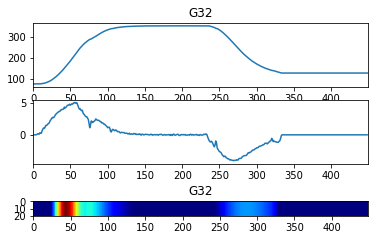

060
Test data number:  60


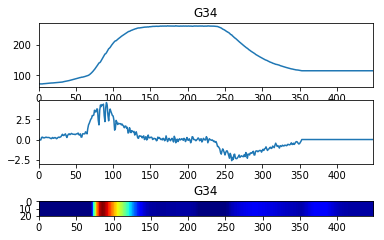

061
Test data number:  61


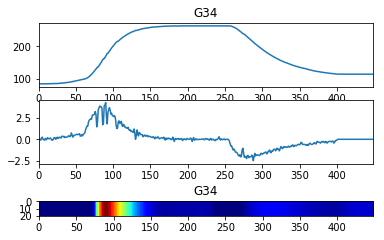

062
Test data number:  62


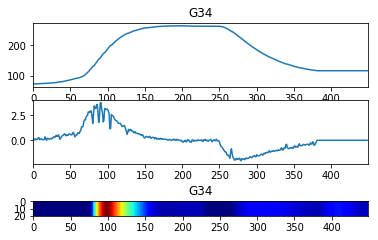

063
Test data number:  63


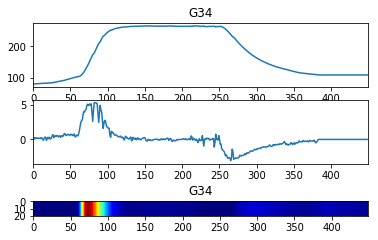

064
Test data number:  64


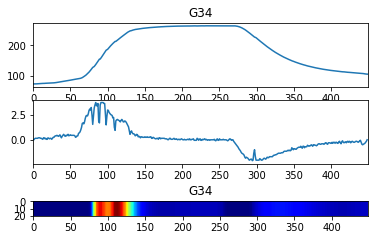

065
Test data number:  65


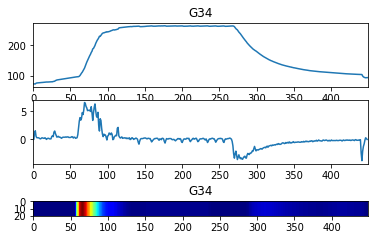

066
Test data number:  66


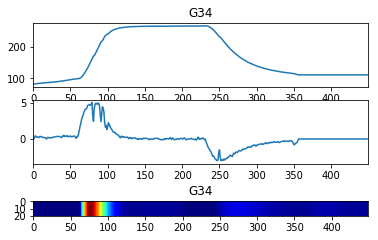

067
Test data number:  67


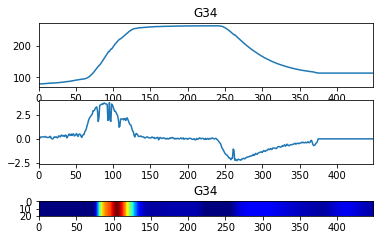

068
Test data number:  68


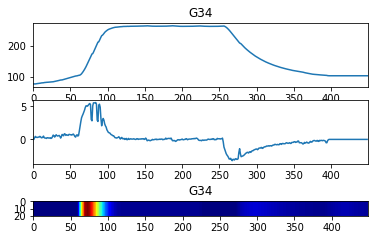

069
Test data number:  69


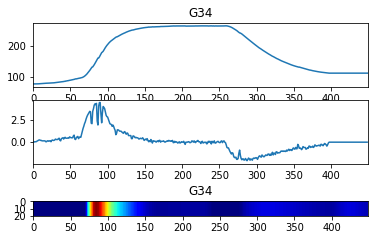

070
Test data number:  70


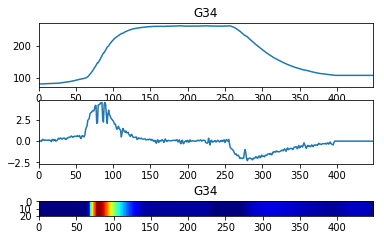

071
Test data number:  71


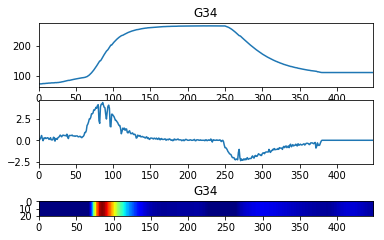

072
Test data number:  72


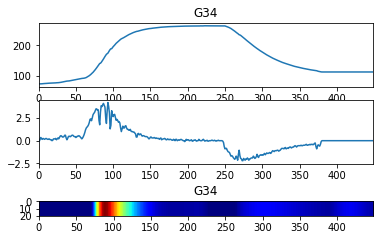

073
Test data number:  73


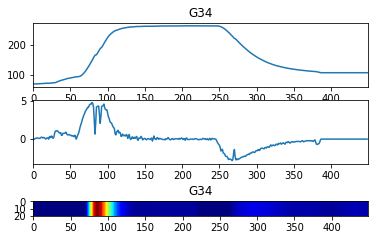

074
Test data number:  74


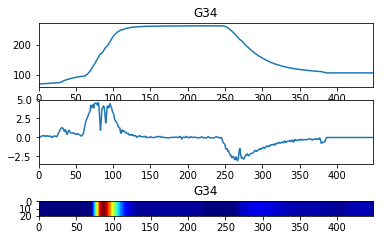

075
Test data number:  75


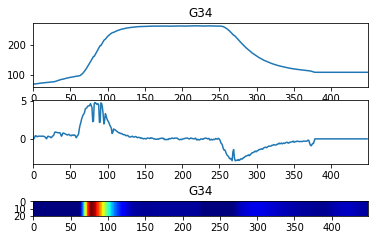

076
Test data number:  76


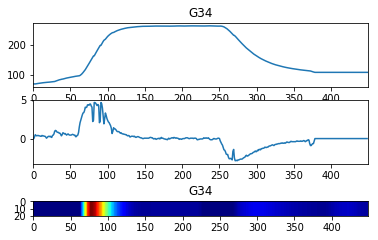

077
Test data number:  77


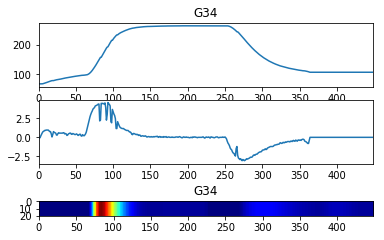

078
Test data number:  78


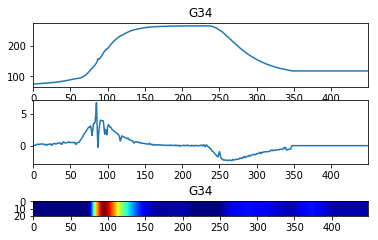

079
Test data number:  79


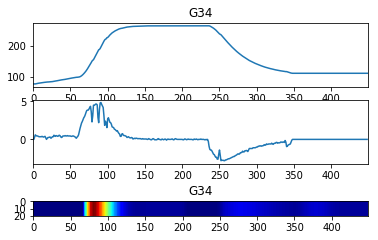

080
Test data number:  80


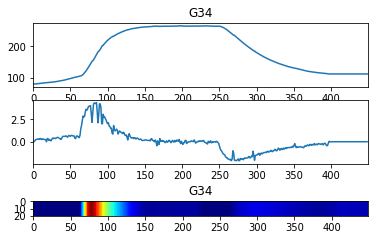

081
Test data number:  81


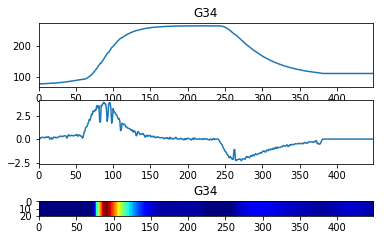

082
Test data number:  82


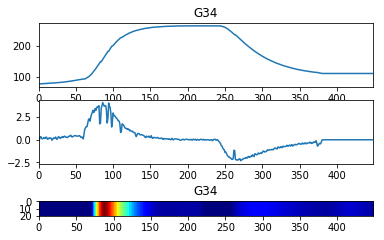

083
Test data number:  83


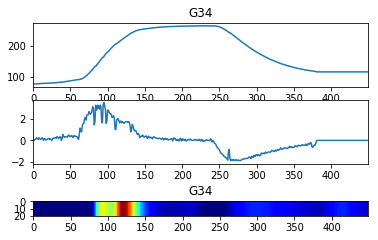

084
Test data number:  84


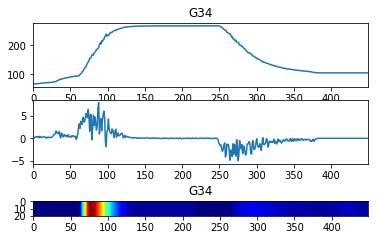

085
Test data number:  85


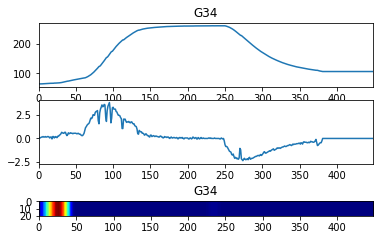

086
Test data number:  86


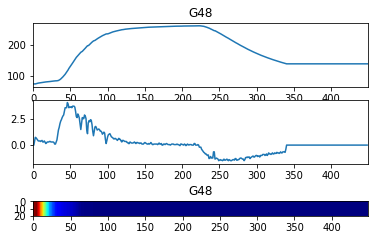

087
Test data number:  87


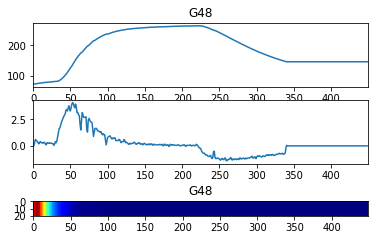

088
Test data number:  88


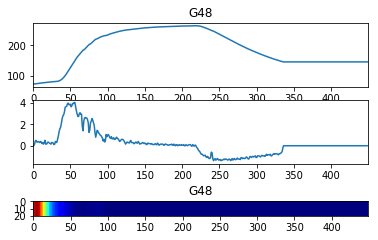

089
Test data number:  89


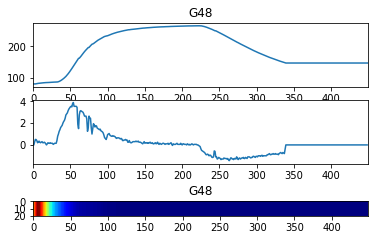

090
Test data number:  90


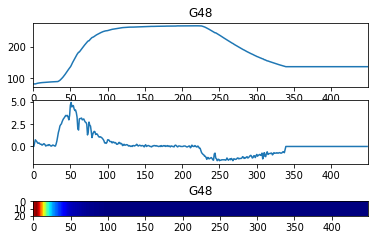

091
Test data number:  91


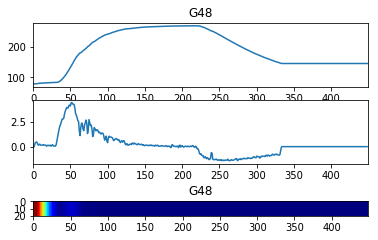

092
Test data number:  92


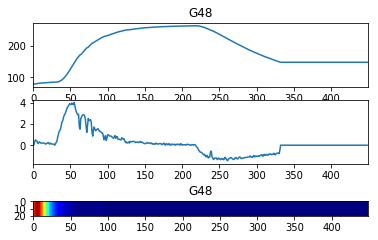

093
Test data number:  93


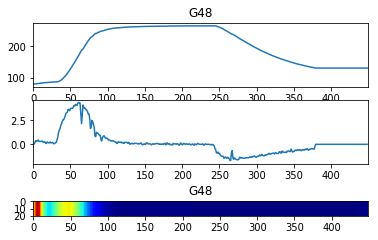

094
Test data number:  94


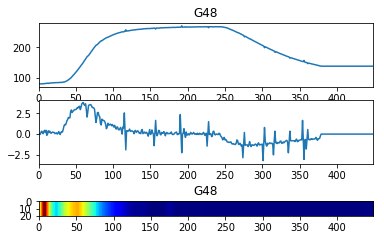

095
Test data number:  95


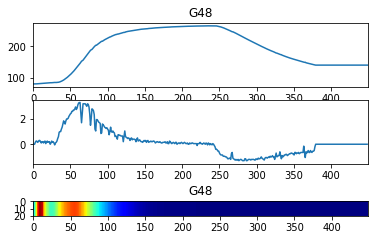

096
Test data number:  96


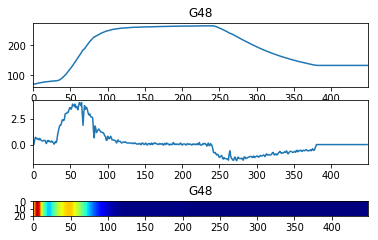

097
Test data number:  97


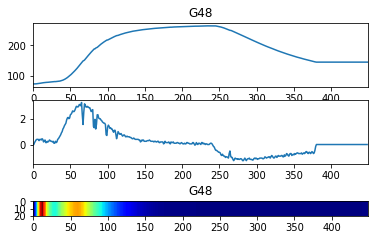

098
Test data number:  98


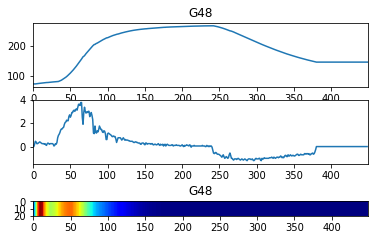

099
Test data number:  99


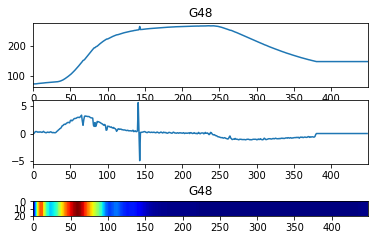

100
Test data number:  100


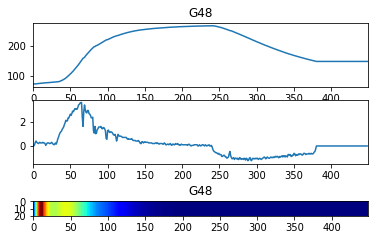

101
Test data number:  101


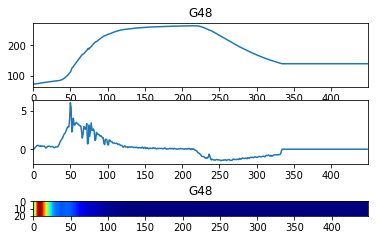

102
Test data number:  102


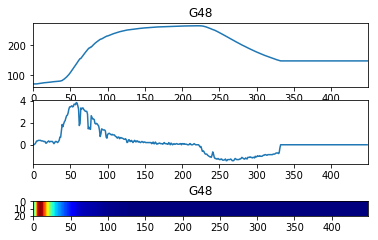

103
Test data number:  103


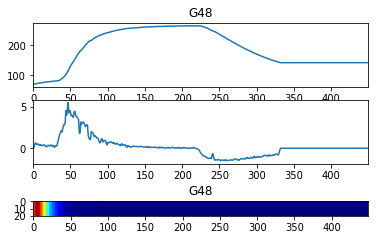

104
Test data number:  104


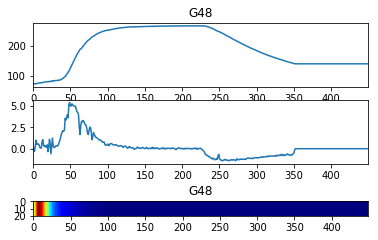

105
Test data number:  105


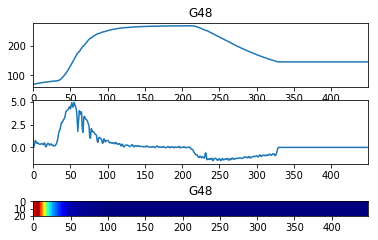

106
Test data number:  106


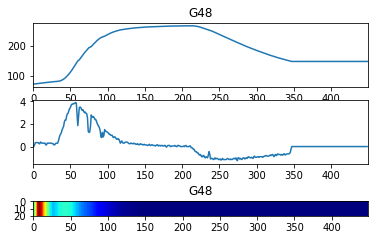

107
Test data number:  107


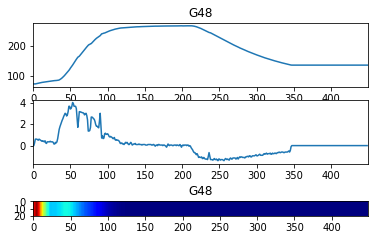

108
Test data number:  108


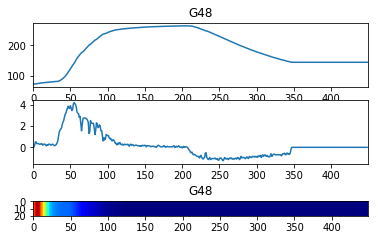

109
Test data number:  109


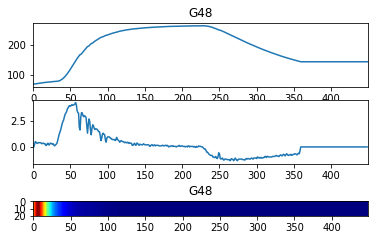

110
Test data number:  110


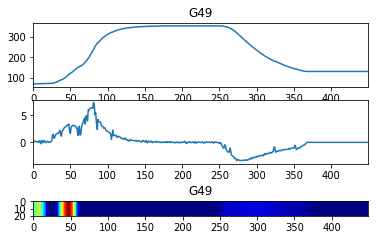

111
Test data number:  111


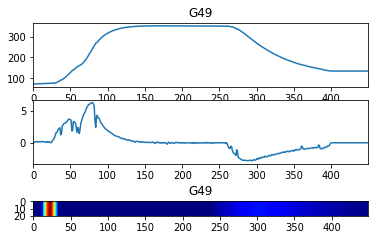

112
Test data number:  112


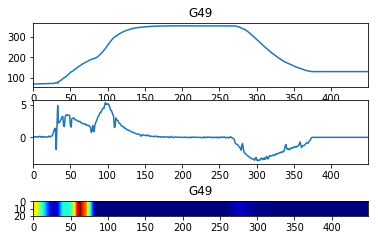

113
Test data number:  113


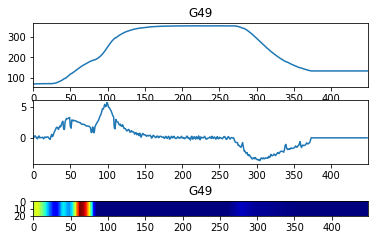

114
Test data number:  114


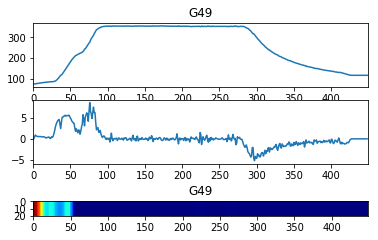

115
Test data number:  115


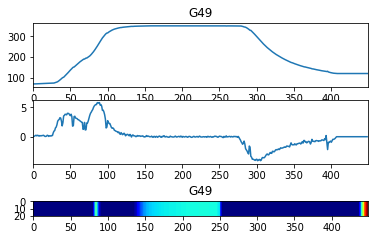

116
Test data number:  116


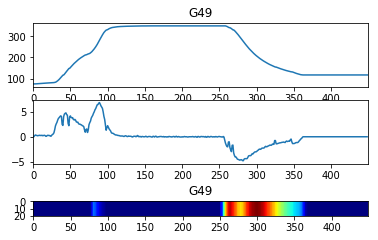

117
Test data number:  117


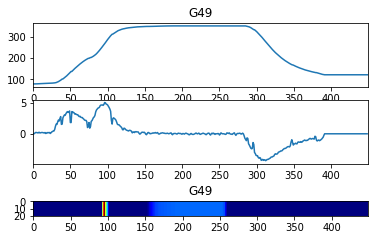

118
Test data number:  118


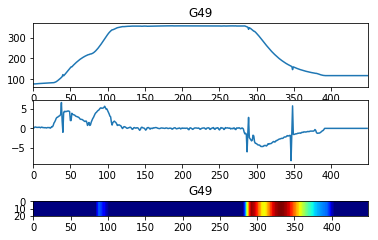

119
Test data number:  119


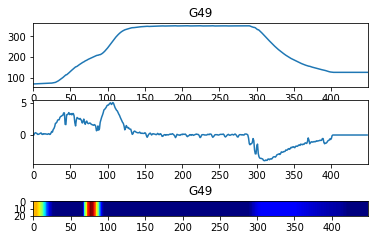

120
Test data number:  120


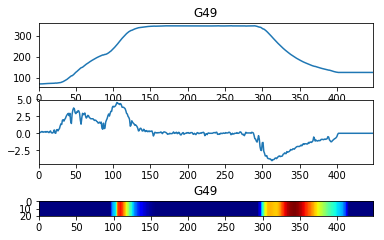

121
Test data number:  121


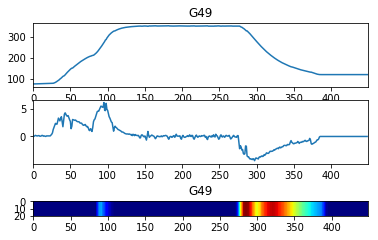

122
Test data number:  122


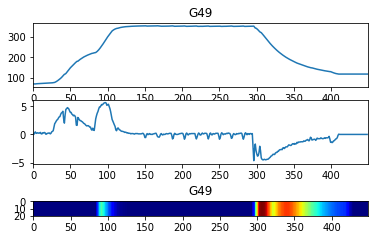

123
Test data number:  123


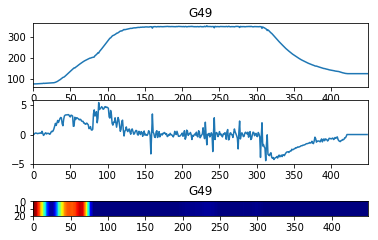

124
Test data number:  124


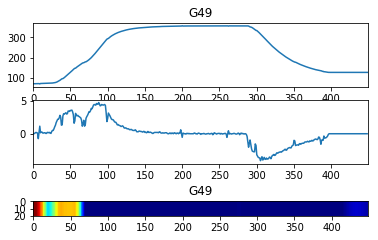

125
Test data number:  125


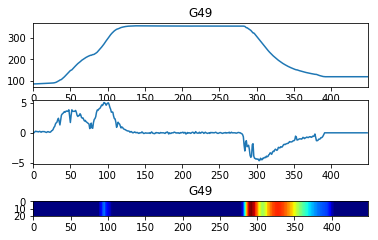

126
Test data number:  126


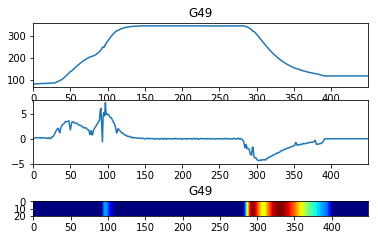

127
Test data number:  127


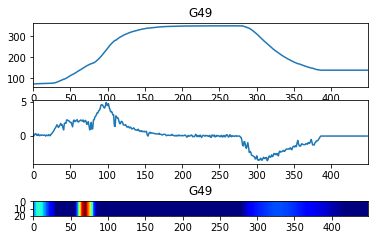

128
Test data number:  128


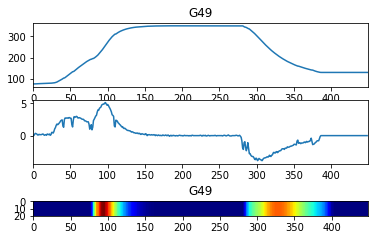

129
Test data number:  129


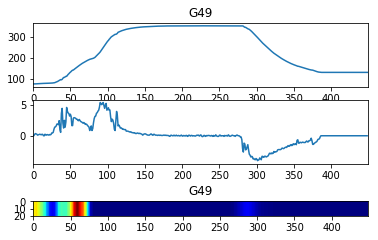

130
Test data number:  130


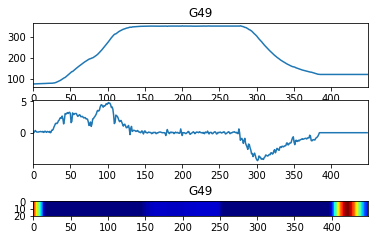

131
Test data number:  131


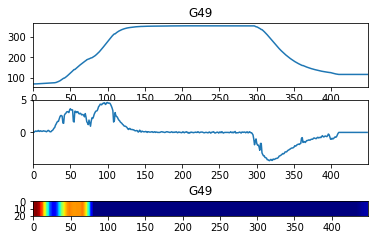

132
Test data number:  132


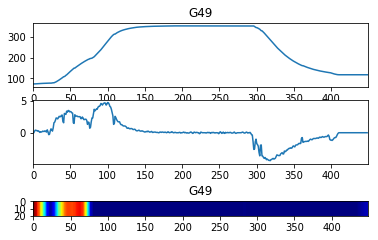

133
Test data number:  133


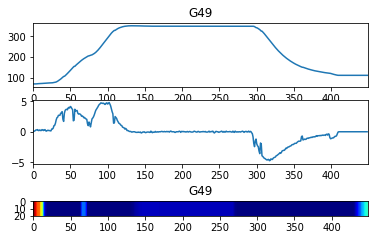

134
Test data number:  134


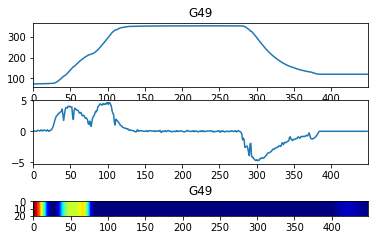

135
Test data number:  135


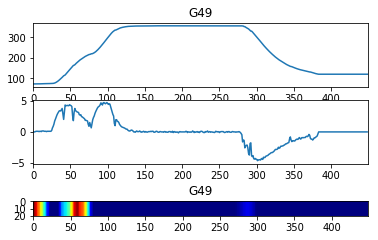

136
Test data number:  136


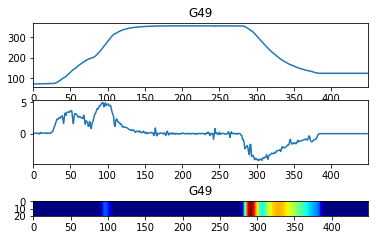

137
Test data number:  137


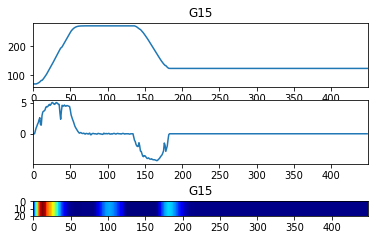

138
Test data number:  138


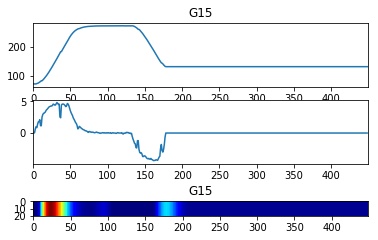

139
Test data number:  139


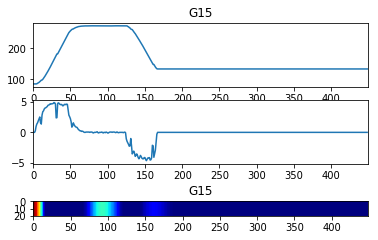

140
Test data number:  140


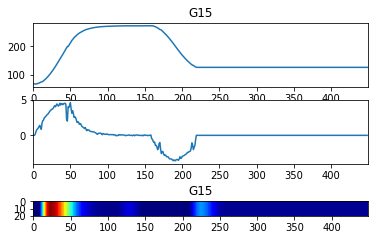

141
Test data number:  141


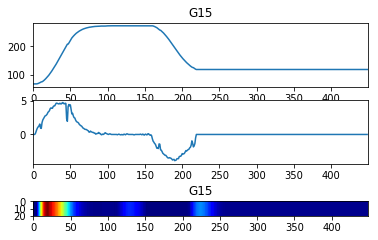

142
Test data number:  142


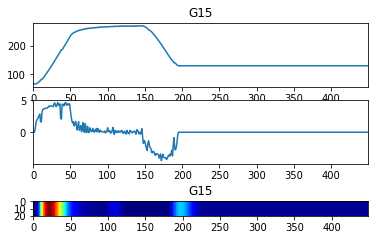

143
Test data number:  143


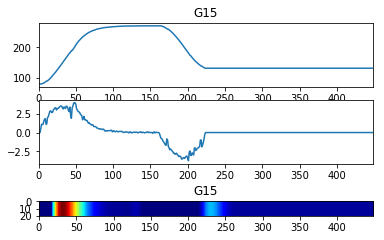

144
Test data number:  144


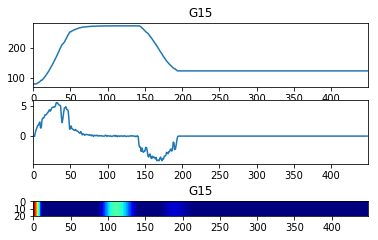

145
Test data number:  145


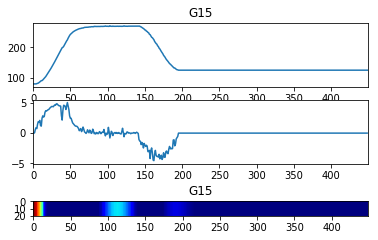

146
Test data number:  146


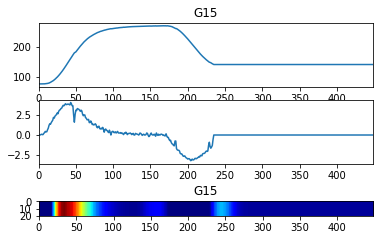

147
Test data number:  147


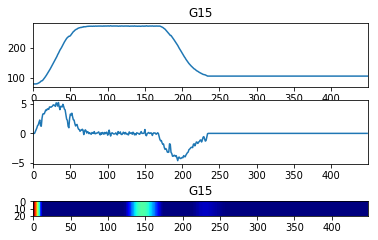

148
Test data number:  148


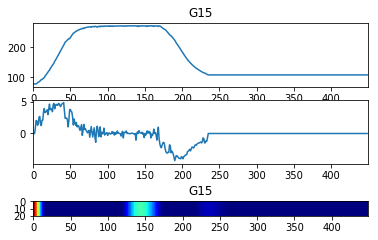

149
Test data number:  149


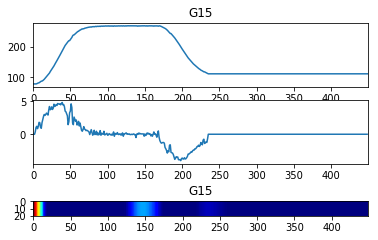

150
Test data number:  150


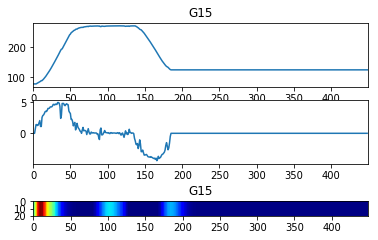

151
Test data number:  151


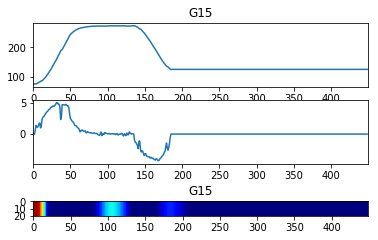

152
Test data number:  152


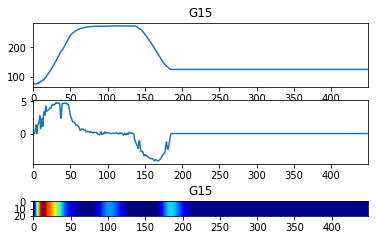

153
Test data number:  153


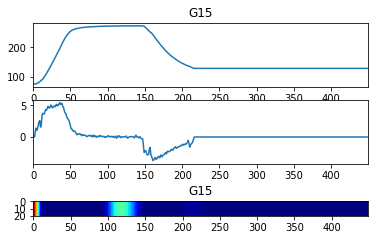

154
Test data number:  154


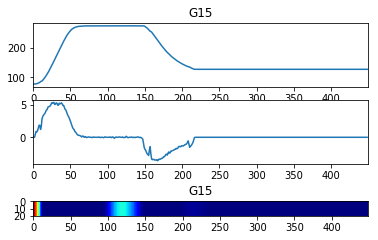

155
Test data number:  155


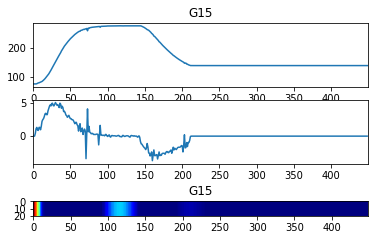

156
Test data number:  156


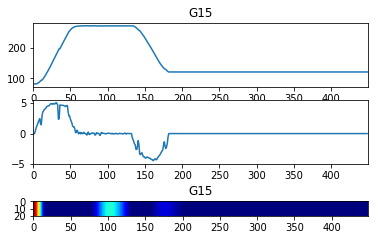

157
Test data number:  157


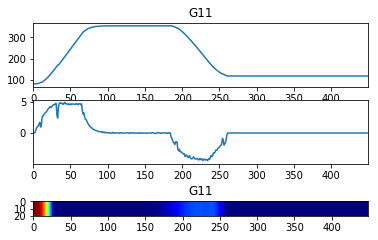

158
Test data number:  158


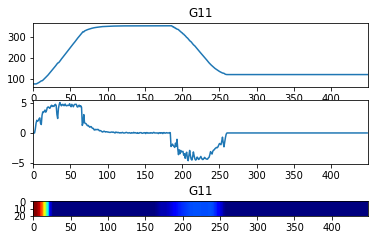

159
Test data number:  159


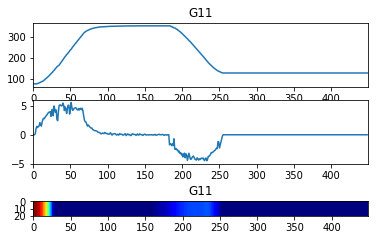

160
Test data number:  160


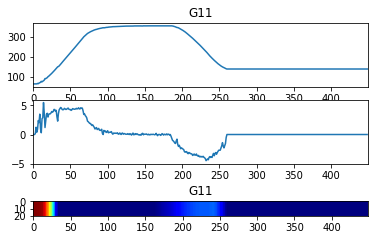

161
Test data number:  161


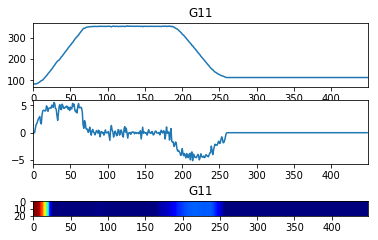

162
Test data number:  162


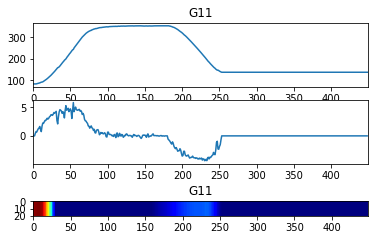

163
Test data number:  163


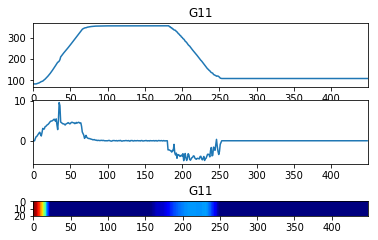

164
Test data number:  164


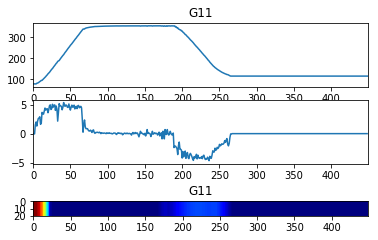

165
Test data number:  165


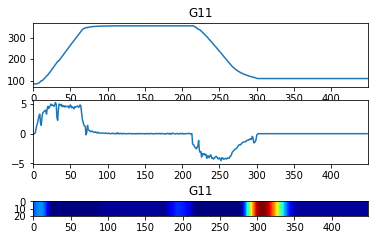

166
Test data number:  166


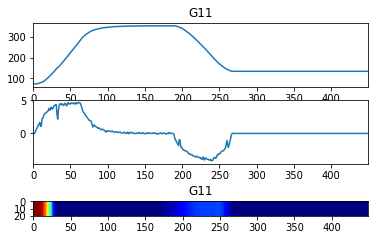

167
Test data number:  167


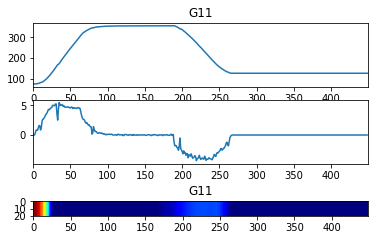

168
Test data number:  168


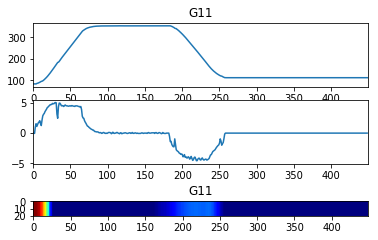

169
Test data number:  169


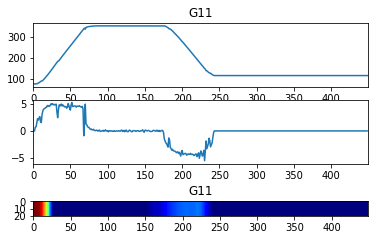

170
Test data number:  170


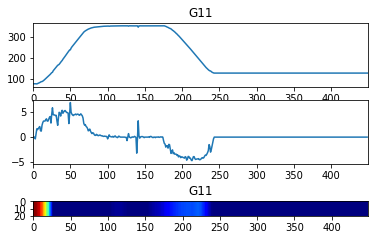

In [59]:
# 將所有10%測試數據都進行可視化分析，並輸出成圖檔儲存
cnt = 0  
for i in range(0,x_all_test.shape[0]):
  str_1 = str(i).zfill(3);
  print(str_1)  
  output_file = rootpath+'Result/VisualizationHeatMap_TrainTest/test_' + str_1 + '.jpg'

  print( "Test data number: ", i)
  test_num = i

  x = x_all_test.iloc[test_num,:]
  x = np.expand_dims(x, axis=0)

  # 取得曲線分類類別
  preds = model.predict(x)
  # pred_class = np.argmax(preds[0])
  L = np.argsort(-preds, axis=1)
  L = L.squeeze()
  # 將preds排序，L為其排序過的index，第1個為最大L[0]，第二個為第二大L[1]，依此類推
  pred_class = L[0]

  # 取得曲線分類名稱
  y_class_name = data_fin.Type.astype('category')
  y_class_name = y_class_name.dtypes.categories 
  y_class_name = y_class_name[pred_class]

  # 預測分類的輸出向量
  pred_output = model.output[:, pred_class]
  #print('pred_output.shape = ',pred_output.shape)

  # 最後一層 convolution layer 輸出的 feature map
  if cnt == 0:
    print(model.summary())
    print('Selected layer: ', model.layers[5].name)
    cnt = cnt+1

  last_conv_layer = model.get_layer(model.layers[5].name)

  # 求得分類的神經元對於最後一層 convolution layer 的梯度
  grads = K.gradients(pred_output, last_conv_layer.output)[0]

  # 求得針對每個 feature map 的梯度加總
  pooled_grads = K.sum(grads, axis=(0, 1))    

  # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
  # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
  # 的方式。
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
  # feature map
  # Sam: pooled_grads_value, shape = [2048,], 是W值
  # Sam: conv_layer_output_value, shape = [7,7,2048]

  pooled_grads_value, conv_layer_output_value = iterate([x])


  # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
  for i in range(pooled_grads_value.shape[0]):
    conv_layer_output_value[:, i] *= (pooled_grads_value[i]) 

  # 計算 feature map 的 channel-wise 加總
  heatmap = np.sum(conv_layer_output_value, axis=-1)

  # 擴充heatmap的維度，方便等等resize成為影像
  heatmap = np.expand_dims(heatmap, axis=0)

  # ReLU
  heatmap = np.maximum(heatmap, 0)
  
  # 正規化
  heatmap /= np.max(heatmap)   
  
  # 拉伸 heatmap
  heatmap = cv2.resize(heatmap, (x.shape[1], 20))

  heatmap = np.uint8(255 * heatmap)

  # 創建figure和axes
  fig, (ax1,ax2,ax3) = plt.subplots(3,1)

  # 繪製曲線圖
  ax1.plot(data_fin.loc[x_all_test.index[test_num]][3:data_fin.shape[1]])
  ax1.set_xlim(0, x.shape[1])
  ax1.set_title(y_class_name)
  
  # 繪製微分曲線圖
  ax2.plot(x[0,:])
  ax2.set_xlim(0, x.shape[1])

  # 繪製熱力圖
  ax3.imshow(heatmap, cmap='jet')
  ax3.set_title(y_class_name)
  plt.savefig(output_file)
  # files.download(output_file)

  plt.figure
  plt.show()
  plt.close('all')

###將所有初賽訓練數據加入進行最終模型建構

In [0]:
# 將訓練與測試數據結合
x_all = np.append(x_all_train,x_all_test,axis=0)
y_dummy_all = np.append(y_all_dummy_train,y_all_dummy_test,axis=0)

In [61]:
# 訓練全部的初賽訓練數據，建構最後模型
model, val_acc, history = evaluate_model(x_all, y_dummy_all, 'model_fin.h5')
print('>%.3f' % val_acc)

Epoch 1/50
 - 2s - loss: 1.7927 - acc: 0.2465
Epoch 2/50
 - 0s - loss: 0.8225 - acc: 0.6841
Epoch 3/50
 - 0s - loss: 0.3057 - acc: 0.8858
Epoch 4/50
 - 0s - loss: 0.1064 - acc: 0.9650
Epoch 5/50
 - 0s - loss: 0.0818 - acc: 0.9749
Epoch 6/50
 - 0s - loss: 0.0816 - acc: 0.9755
Epoch 7/50
 - 0s - loss: 0.0450 - acc: 0.9878
Epoch 8/50
 - 0s - loss: 0.0437 - acc: 0.9872
Epoch 9/50
 - 0s - loss: 0.0398 - acc: 0.9854
Epoch 10/50
 - 0s - loss: 0.0399 - acc: 0.9866
Epoch 11/50
 - 0s - loss: 0.0356 - acc: 0.9866
Epoch 12/50
 - 0s - loss: 0.0394 - acc: 0.9872
Epoch 13/50
 - 0s - loss: 0.0450 - acc: 0.9872
Epoch 14/50
 - 0s - loss: 0.0279 - acc: 0.9901
Epoch 15/50
 - 0s - loss: 0.0290 - acc: 0.9913
Epoch 16/50
 - 0s - loss: 0.1416 - acc: 0.9697
Epoch 17/50
 - 0s - loss: 0.4289 - acc: 0.8986
Epoch 18/50
 - 0s - loss: 0.0520 - acc: 0.9895
Epoch 19/50
 - 0s - loss: 0.0310 - acc: 0.9918
Epoch 20/50
 - 0s - loss: 0.0365 - acc: 0.9889
Epoch 21/50
 - 0s - loss: 0.0236 - acc: 0.9907
Epoch 22/50
 - 0s - lo

In [62]:
y_probs_all = model.predict_proba(x_all) 
print(y_probs_all.shape) #矩陣大小
print(y_probs_all[0:4,:]) #只顯示前五列

(1716, 8)
[[9.9998403e-01 1.4907724e-05 5.2347127e-07 4.6546301e-18 6.4038767e-07
  6.3413503e-21 2.5143895e-16 1.7707974e-14]
 [9.9998069e-01 7.3627307e-06 2.4832881e-08 4.4564772e-21 1.1969518e-05
  1.5713990e-20 4.4933242e-17 1.3707552e-13]
 [9.9971861e-01 4.0284368e-07 6.0793366e-07 8.9460359e-19 2.8044352e-04
  3.0394426e-19 8.3009356e-15 3.4654688e-12]
 [9.9999678e-01 5.3084153e-07 9.9765565e-08 9.6630375e-21 2.5811842e-06
  6.0380113e-20 1.7395378e-16 4.9040004e-13]]


In [63]:
# 數字轉換分類結果
ind = np.argmax(y_probs_all,1)
y_prdict_all = data_fin.Type.astype('category')
y_prdict_all = y_prdict_all.dtypes.categories 
y_prdict_all = y_prdict_all[ind]
y_prdict_all = pd.Series(y_prdict_all)

ind = np.argmax(y_dummy_all,1)
y_all = data_fin.Type.astype('category')
y_all = y_all.dtypes.categories 
y_all = y_all[ind]
y_all = pd.Series(y_all)

# 測試數據，預測準確度
# evaluate predictions
accuracy = accuracy_score(y_all, y_prdict_all)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


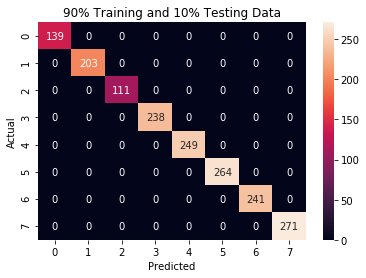

In [64]:
# 畫出confusion matrix
cm = confusion_matrix(y_all,y_prdict_all)
ax = sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual', title='90% Training and 10% Testing Data')
np.shape(y_all)

figure = ax.get_figure()    
output_file = rootpath+'Result/Plot/all_confusion_matrix.jpg'
figure.savefig(output_file)

#初賽測試數據

##讀取並整理初賽測試數據

In [65]:
# 進入初賽訓練數據資料夾
os.chdir(rootpath+'thubigdata2019exam-722')

# 秀出當前路徑內檔案，確認是否在正確的路徑下
files = [f for f in os.listdir('.') if os.path.isfile(f)]

print(files)
print('Number of files:',len(files))

['5.txt', '9.txt', '7.txt', '30.txt', '31.txt', '32.txt', '34.txt', '8.txt', '33.txt', '3.txt', '4.txt', '6.txt', '36.txt', '35.txt', '19.txt', '2.txt', '21.txt', '22.txt', '20.txt', '23.txt', '28.txt', '29.txt', '27.txt', '26.txt', '25.txt', '18.txt', '16.txt', '1.txt', '12.txt', '10.txt', '11.txt', '24.txt', '17.txt', '15.txt', '14.txt', '13.txt']
Number of files: 36


In [66]:
# 利用迴圈將所有資料夾內檔案整合成一個dataframe
init_cnt = 0
os.chdir(rootpath+'thubigdata2019exam-722')

for i in files:    
  data_tmp = pd.read_csv(i, sep='\\t', engine='python', index_col=False)
  data_tmp = data_tmp.transpose()   
  data_tmp = data_tmp.drop([0],axis=1) #丟掉溫度單位(Deg.F)
  data_tmp = data_tmp.astype(float) #將string轉換成float

  data_tmp.insert(0,'Type',np.nan)
  data_tmp.insert(0,'FileName',i)      

  if init_cnt == 0:
    data_test = data_tmp
    init_cnt += 1
  else:
    data_test = data_test.append(data_tmp,sort=False) 
    
data_test = data_test.reset_index()
data_test = data_test.rename(columns={"index":"Col"})

# 加長時間長度和訓練一樣
for i in range(data_test.shape[1]-3,data.shape[1]-2):
  data_test[i] = np.nan
    
print(data_test.head())
print(data_test.shape)

           Col FileName  Type     1     2     3  ...  444  445  446  447  448  449
0       PTC1      5.txt   NaN  79.8  79.8  79.8  ...  NaN  NaN  NaN  NaN  NaN  NaN
1       PTC2      5.txt   NaN  79.7  79.7  79.7  ...  NaN  NaN  NaN  NaN  NaN  NaN
2       PTC3      5.txt   NaN  80.1  80.1  80.1  ...  NaN  NaN  NaN  NaN  NaN  NaN
3       PTC4      5.txt   NaN  78.8  78.8  78.8  ...  NaN  NaN  NaN  NaN  NaN  NaN
4       PTC5      5.txt   NaN  78.2  78.2  78.2  ...  NaN  NaN  NaN  NaN  NaN  NaN

[5 rows x 452 columns]
(276, 452)


##初賽測試數據的設置分配與前處理

###對時間溫度曲線數據進行微分

In [0]:
m, n = data_test.shape
x_tmp1 = data_test.iloc[:,3:n].values.copy()
x_tmp2 = data_test.iloc[:,3:n].values.copy()
data_test_diff = data_test.copy()

for i in range(0,m):
  f = x_tmp1[i,0:n]

  ind = np.isnan(f)
  f[np.isnan(f)] = f[f.shape[0]-ind.sum()-1]

  fg = np.gradient(f)

  x_tmp1[i,0:n] = f
  x_tmp2[i,0:n] = fg

data_test.iloc[:,3:n] = x_tmp1
data_test_diff.iloc[:,3:n] = x_tmp2

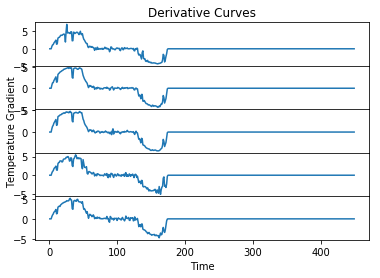

In [68]:
# 畫出test前5個微分的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_test_diff.iloc[i,3:n])

    if i == 0:
      plt.title('Derivative Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature Gradient')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/derivative_curves_test.jpg'
figure.savefig(output_file)

###檢查是否有不穩定的時間溫度曲線

In [0]:
# 對微分數值設閾值，篩選不穩定之時間溫度曲線
ind_bad_test = []
m, n = data_test_diff.shape

for i in range(0,m):
  tmp = data_test_diff.iloc[i,3:n].values.copy()
  
  if abs(tmp.min())>15 or abs(tmp.max())>15:
    ind_bad_test = ind_bad_test + [i]

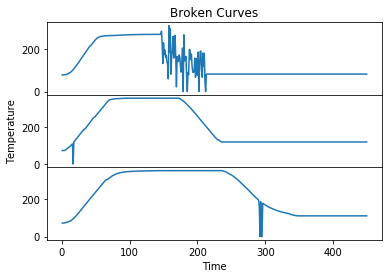

In [70]:
# 畫出壞掉的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=len(ind_bad_test)

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_test.iloc[ind_bad_test[i],3:data_test.shape[1]])
    
    if i == 0:
      plt.title('Broken Curves')
    elif i == round(number_of_subplots/2)-1:
      plt.ylabel('Temperature')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/broken_curves_true_test.jpg'
figure.savefig(output_file)

###設置初賽測試數據格式

In [0]:
# 設置x和y
x_true_test = data_test_diff.drop(['Col','FileName','Type'],axis=1)

# 將y做成one-hot encoding
# 要注意不同模型訓練的時候丟入的y有可能是原本0和1(y_train)，或是經過one-hot encoding的(y_dummy)
y_true_test = data_test_diff['Type']
y_dummy_true_test = pd.get_dummies(y_true_test)

In [72]:
# 檢視設置結果
print('true test:')
print('x:',x_true_test.shape)
print(x_true_test.head(3))
print('y:',y_dummy_true_test.shape)
print(y_dummy_true_test.head(3))

true test:
x: (276, 449)
   1    2    3     4     5     6     7    ...  443  444  445  446  447  448  449
0  0.0  0.0  0.0  0.65  1.10  1.20  1.65  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.70  1.25  1.30  1.75  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.75  1.30  1.55  2.05  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[3 rows x 449 columns]
y: (276, 0)
Empty DataFrame
Columns: []
Index: [0, 1, 2]


##已訓練模型讀取與結果預測

In [0]:
# 進入儲存模型資料夾
os.chdir(rootpath+'Result/Model')
model.load_weights('model_fin.h5') #讀取模型

In [74]:
# 預測測試數據結果
y_probs_true_test = model.predict_proba(x_true_test) 
print(y_probs_true_test.shape) #矩陣大小
print(y_probs_true_test[0:4,:]) #只顯示前五列

(276, 8)
[[2.01590623e-07 9.99999762e-01 3.82809590e-10 1.08257794e-08
  1.67671464e-18 1.26249309e-24 6.70684745e-23 7.44784978e-25]
 [2.42469980e-07 9.99999642e-01 5.75414272e-10 6.32198720e-08
  3.03966045e-18 3.49163090e-24 9.02794129e-23 1.32627496e-24]
 [2.84648650e-07 9.99999762e-01 3.82878257e-10 1.31209985e-08
  2.13473975e-18 2.65418602e-24 7.10137509e-23 1.32177993e-24]
 [1.30528377e-07 9.99999881e-01 2.41179104e-10 1.98984083e-08
  3.01207274e-19 6.26115301e-25 2.11872814e-23 1.84749930e-25]]


In [0]:
# 數字轉換分類結果
ind = np.argmax(y_probs_true_test,1)
y_prdict_true_test = data_fin.Type.astype('category')
y_prdict_true_test = y_prdict_true_test.dtypes.categories 
y_prdict_true_test = y_prdict_true_test[ind]
y_prdict_true_test = pd.Series(y_prdict_true_test)

# 將預測結果填入
data_test['Type'] = y_prdict_true_test

##預測結果輸出

###分類依據可視化分析

透過可視化分析，能夠知道模型是針對哪些時間段，對時間溫度曲線進行分類，在熱力圖中，會依照藍到紅顯示，越紅表示越重要。

000
Test data number:  0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 449, 1)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 440, 100)          1100      
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 431, 100)          100100    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 143, 100)          0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 134, 160)          160160    
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 125, 160)          256160    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 160)           

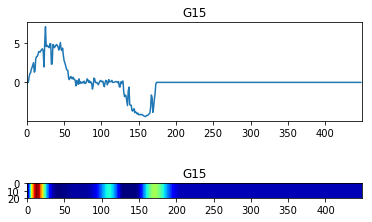

001
Test data number:  1


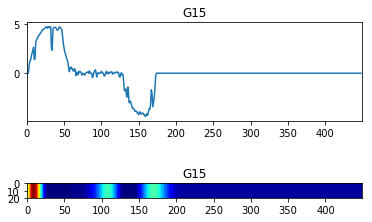

002
Test data number:  2


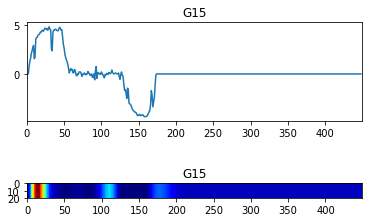

003
Test data number:  3


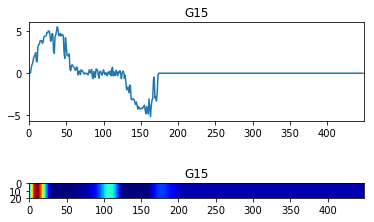

004
Test data number:  4


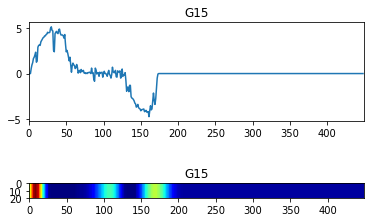

005
Test data number:  5


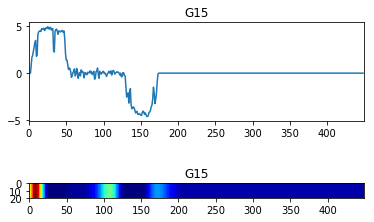

006
Test data number:  6


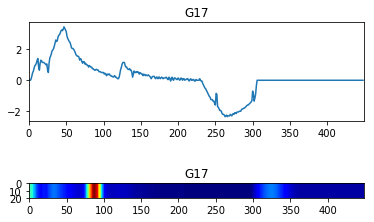

007
Test data number:  7


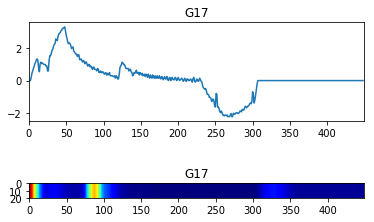

008
Test data number:  8


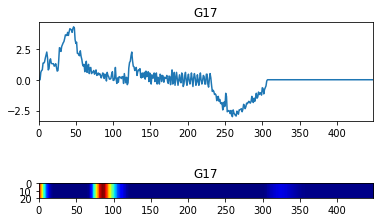

009
Test data number:  9


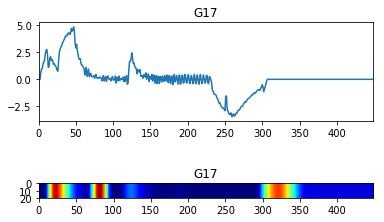

010
Test data number:  10


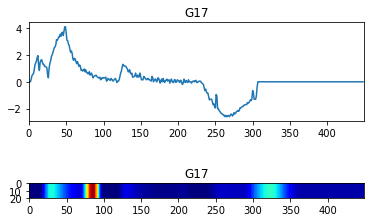

011
Test data number:  11


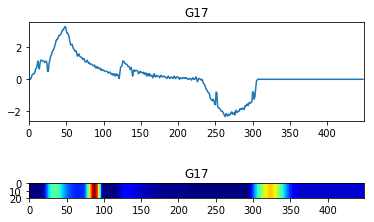

012
Test data number:  12


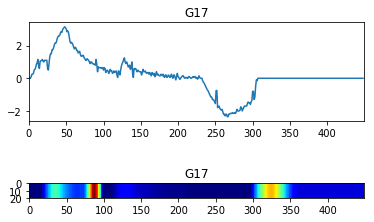

013
Test data number:  13


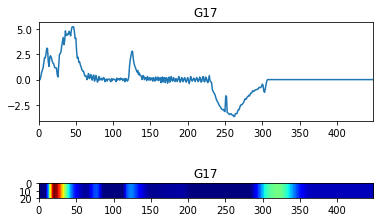

014
Test data number:  14


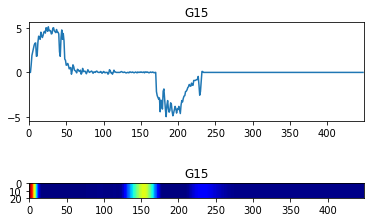

015
Test data number:  15


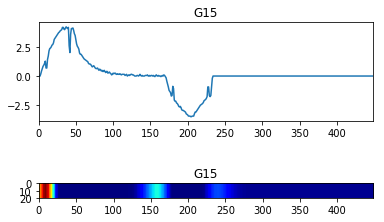

016
Test data number:  16


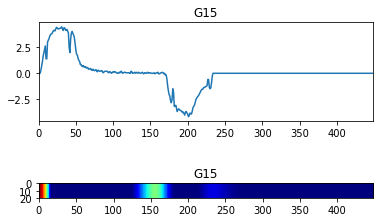

017
Test data number:  17


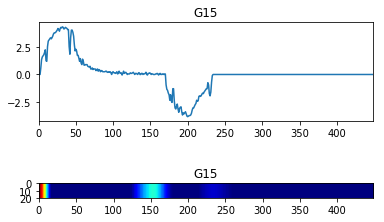

018
Test data number:  18


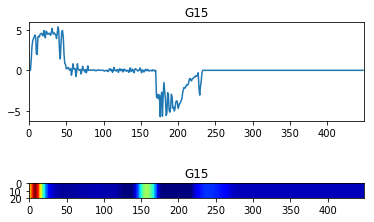

019
Test data number:  19


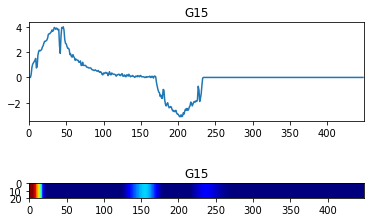

020
Test data number:  20


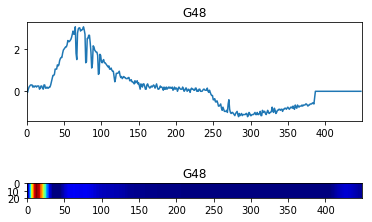

021
Test data number:  21


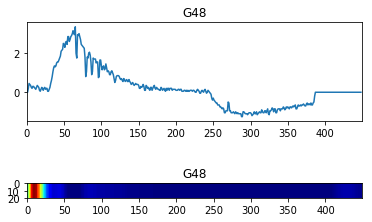

022
Test data number:  22


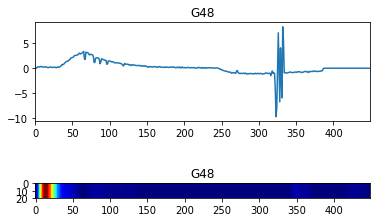

023
Test data number:  23


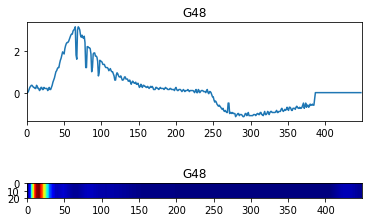

024
Test data number:  24


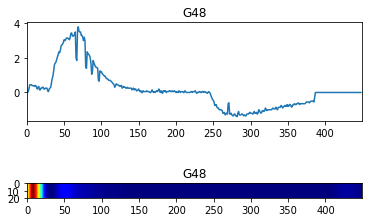

025
Test data number:  25


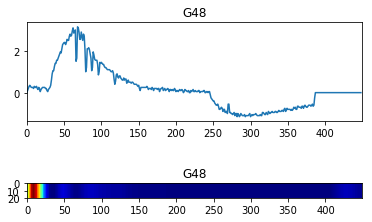

026
Test data number:  26


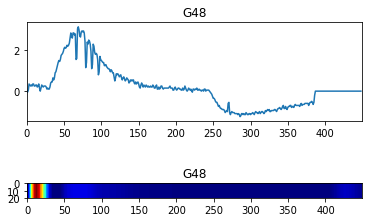

027
Test data number:  27


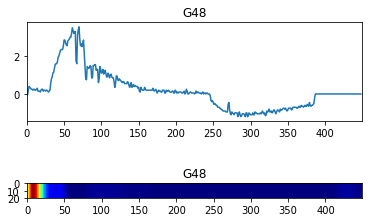

028
Test data number:  28


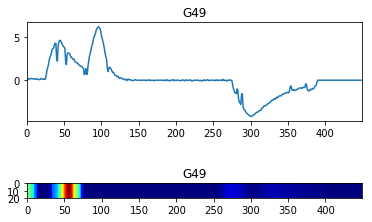

029
Test data number:  29


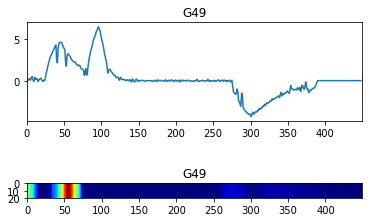

030
Test data number:  30


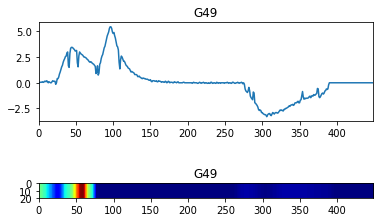

031
Test data number:  31


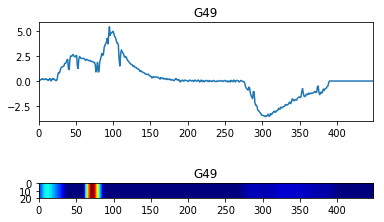

032
Test data number:  32


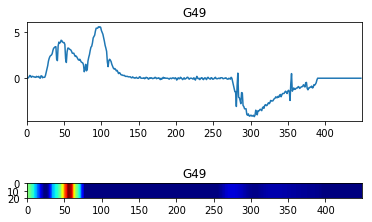

033
Test data number:  33


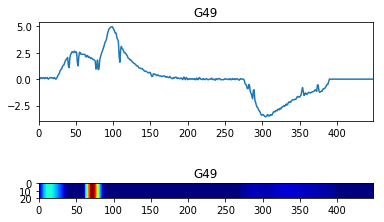

034
Test data number:  34


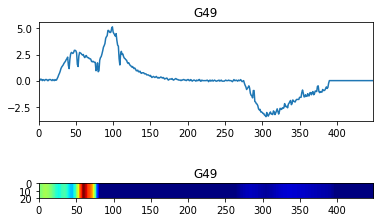

035
Test data number:  35


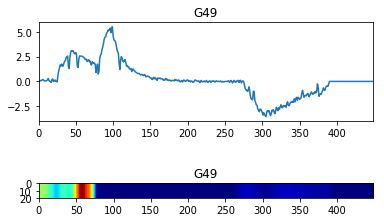

036
Test data number:  36


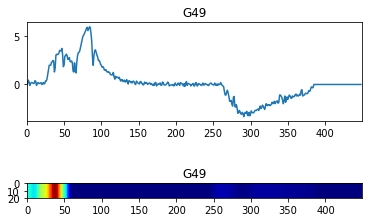

037
Test data number:  37


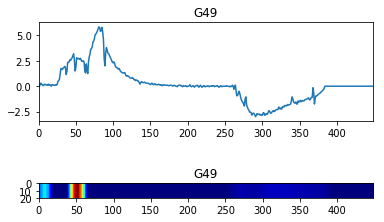

038
Test data number:  38


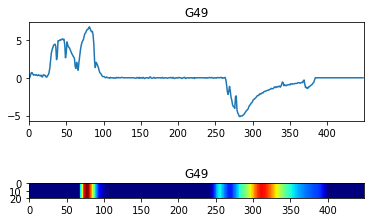

039
Test data number:  39


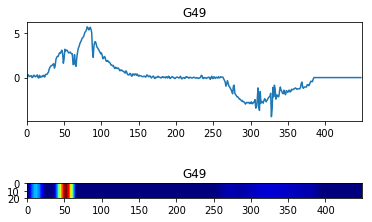

040
Test data number:  40


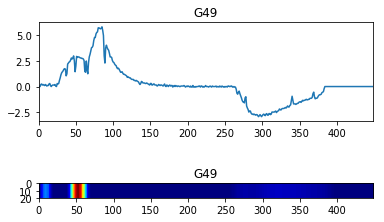

041
Test data number:  41


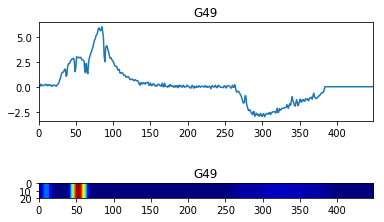

042
Test data number:  42


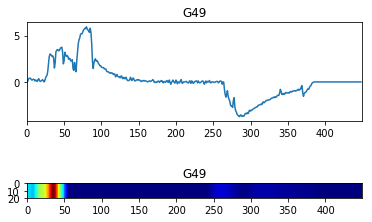

043
Test data number:  43


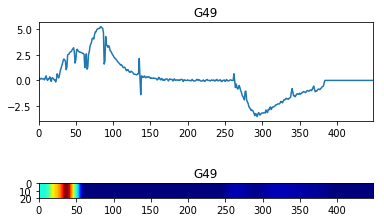

044
Test data number:  44


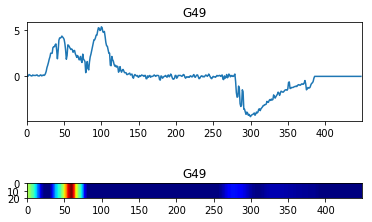

045
Test data number:  45


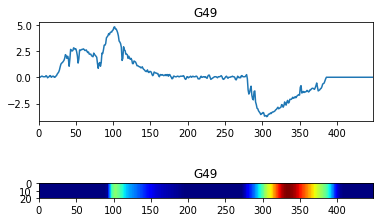

046
Test data number:  46


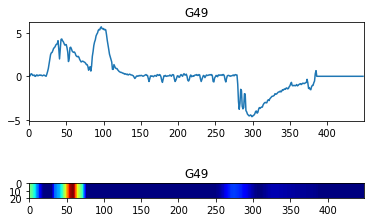

047
Test data number:  47


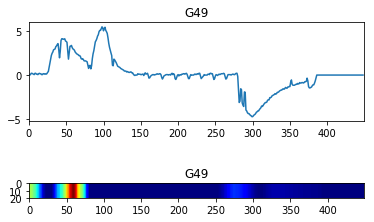

048
Test data number:  48


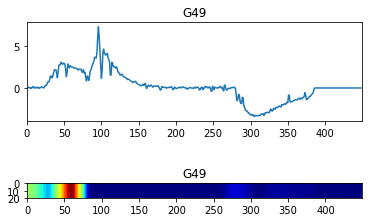

049
Test data number:  49


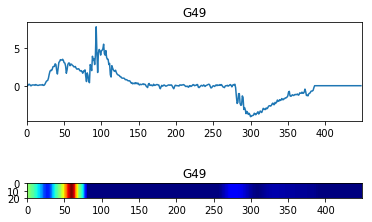

050
Test data number:  50


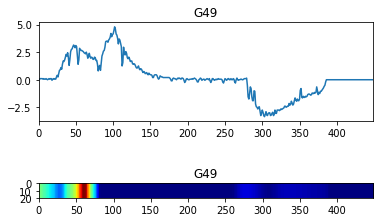

051
Test data number:  51


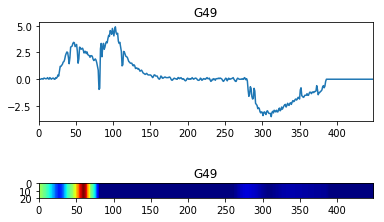

052
Test data number:  52


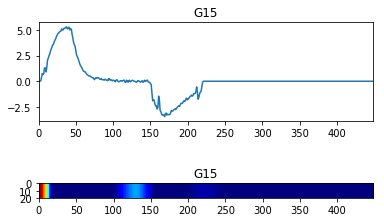

053
Test data number:  53


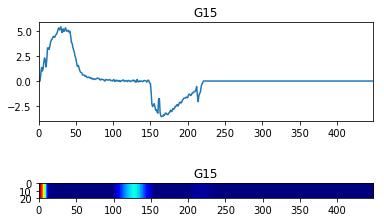

054
Test data number:  54


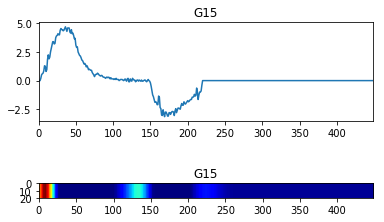

055
Test data number:  55


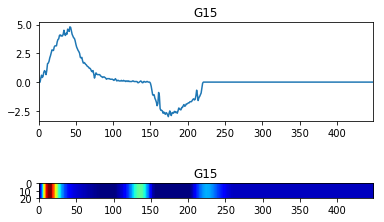

056
Test data number:  56


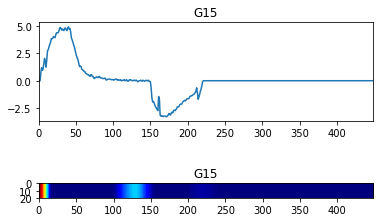

057
Test data number:  57


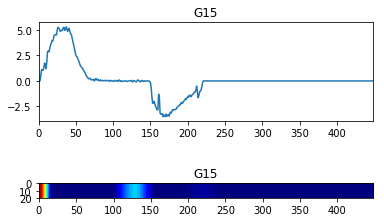

058
Test data number:  58


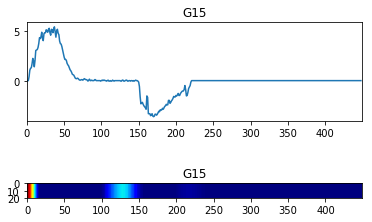

059
Test data number:  59


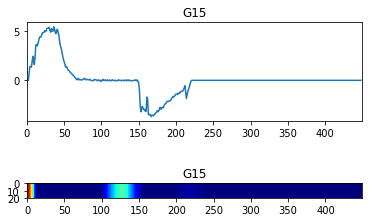

060
Test data number:  60


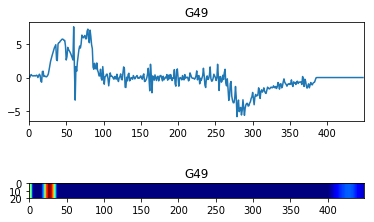

061
Test data number:  61


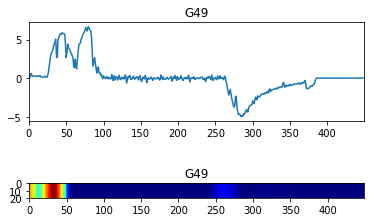

062
Test data number:  62


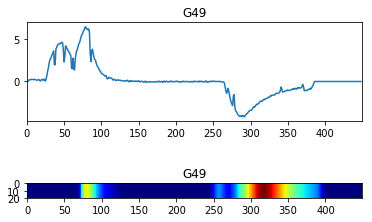

063
Test data number:  63


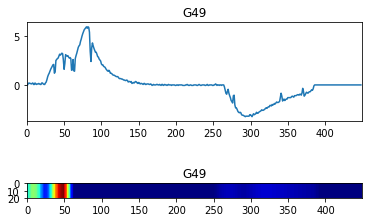

064
Test data number:  64


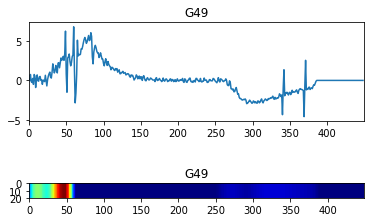

065
Test data number:  65


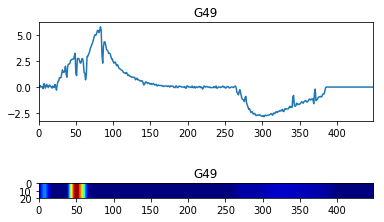

066
Test data number:  66


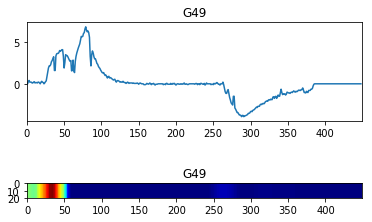

067
Test data number:  67


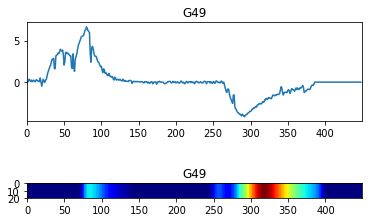

068
Test data number:  68


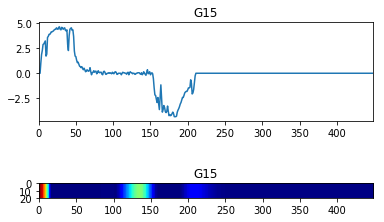

069
Test data number:  69


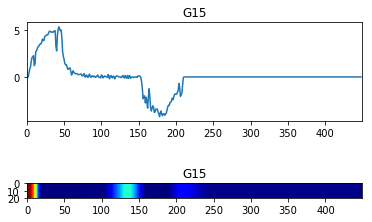

070
Test data number:  70


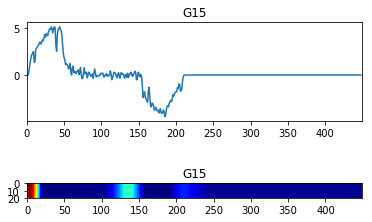

071
Test data number:  71


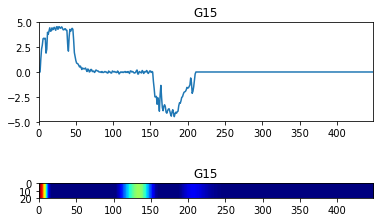

072
Test data number:  72


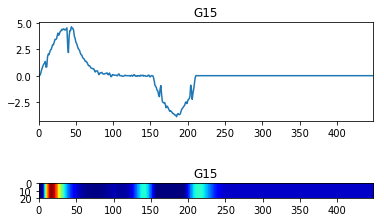

073
Test data number:  73


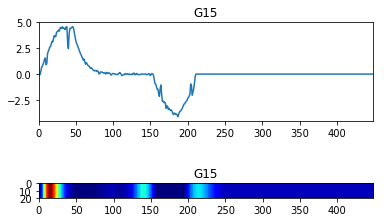

074
Test data number:  74


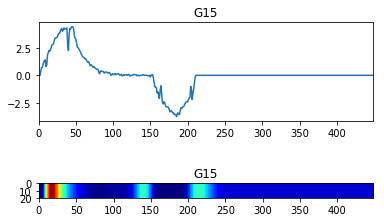

075
Test data number:  75


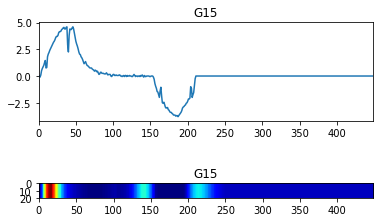

076
Test data number:  76


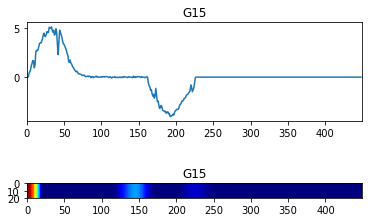

077
Test data number:  77


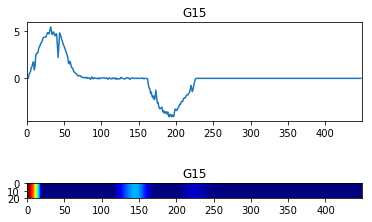

078
Test data number:  78


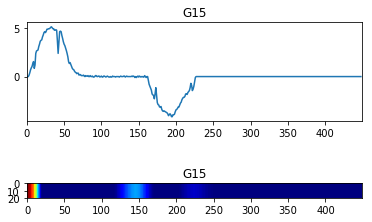

079
Test data number:  79


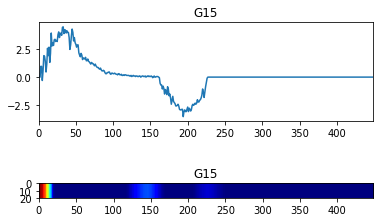

080
Test data number:  80


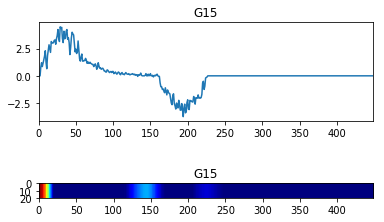

081
Test data number:  81


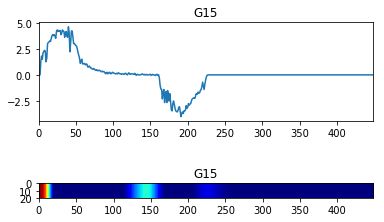

082
Test data number:  82


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


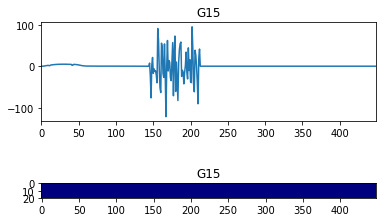

083
Test data number:  83


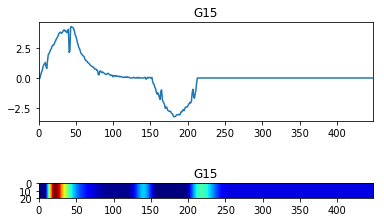

084
Test data number:  84


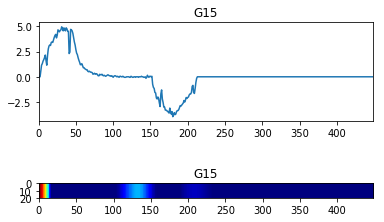

085
Test data number:  85


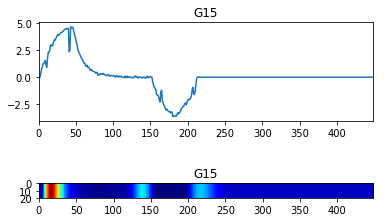

086
Test data number:  86


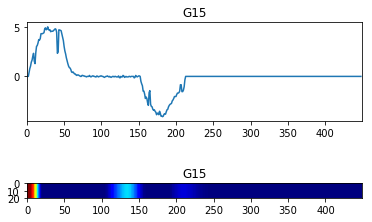

087
Test data number:  87


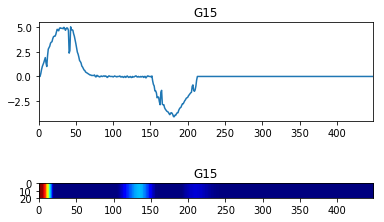

088
Test data number:  88


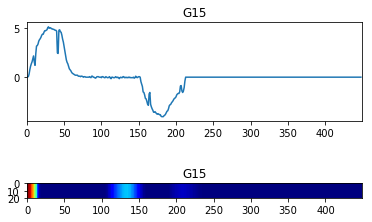

089
Test data number:  89


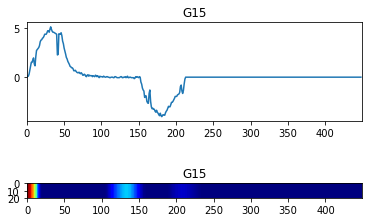

090
Test data number:  90


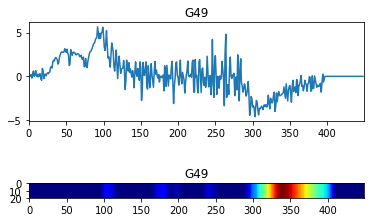

091
Test data number:  91


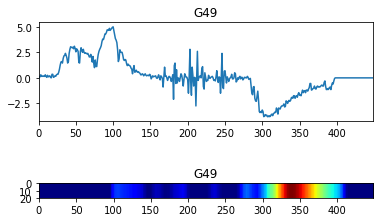

092
Test data number:  92


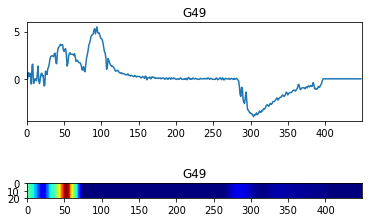

093
Test data number:  93


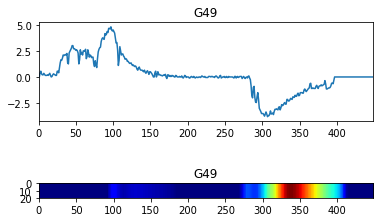

094
Test data number:  94


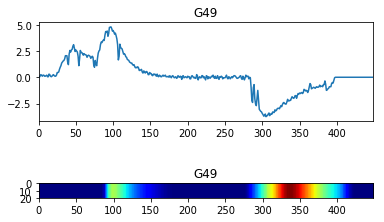

095
Test data number:  95


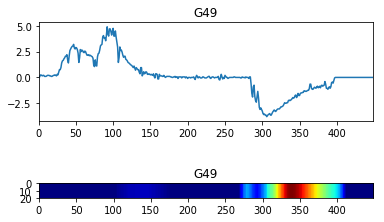

096
Test data number:  96


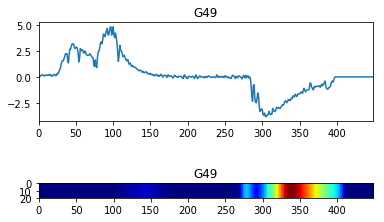

097
Test data number:  97


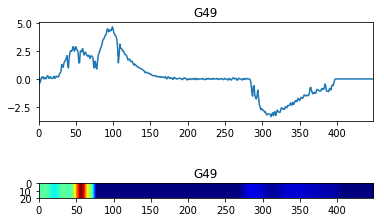

098
Test data number:  98


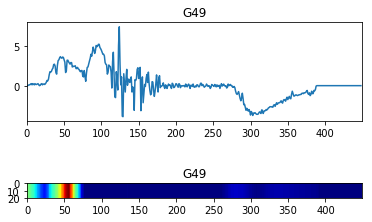

099
Test data number:  99


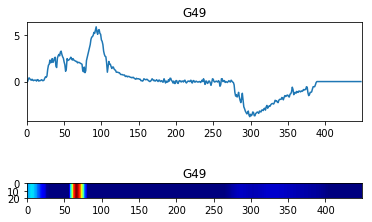

100
Test data number:  100


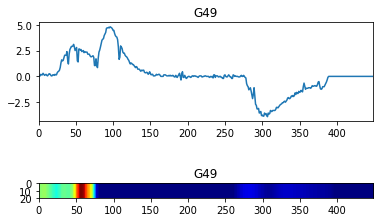

101
Test data number:  101


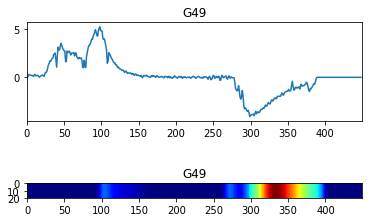

102
Test data number:  102


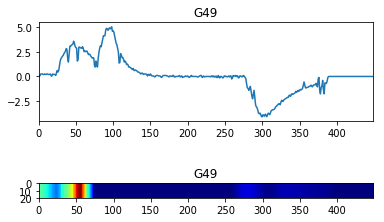

103
Test data number:  103


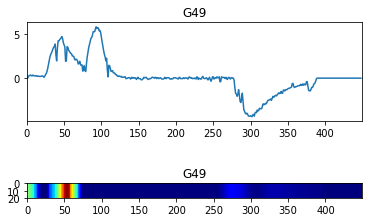

104
Test data number:  104


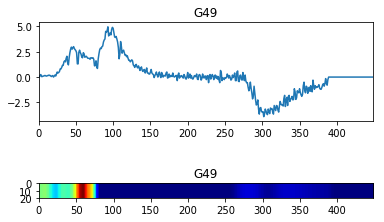

105
Test data number:  105


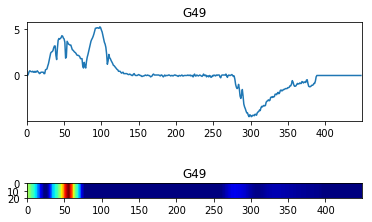

106
Test data number:  106


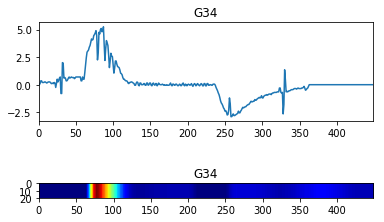

107
Test data number:  107


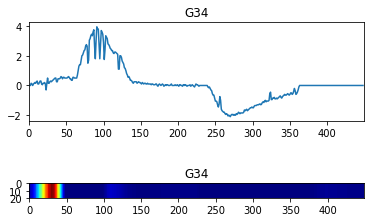

108
Test data number:  108


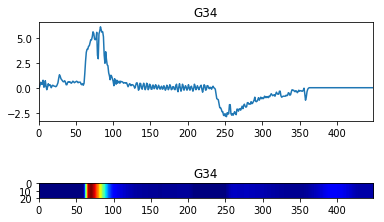

109
Test data number:  109


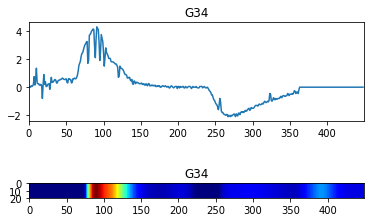

110
Test data number:  110


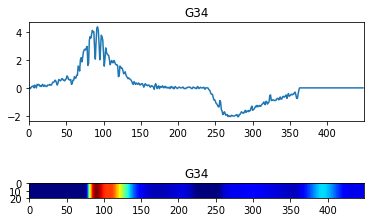

111
Test data number:  111


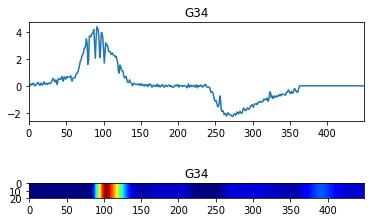

112
Test data number:  112


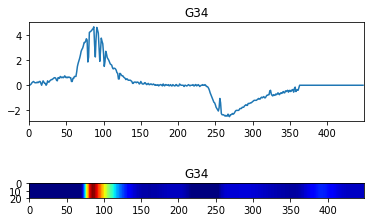

113
Test data number:  113


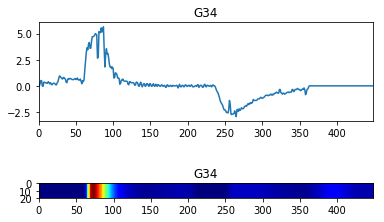

114
Test data number:  114


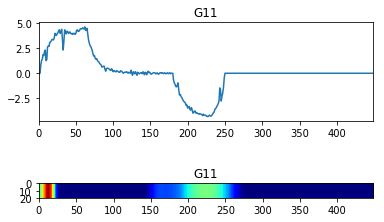

115
Test data number:  115


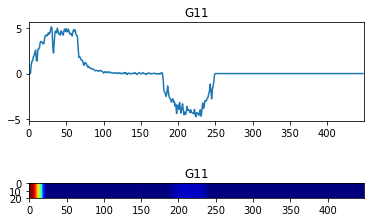

116
Test data number:  116


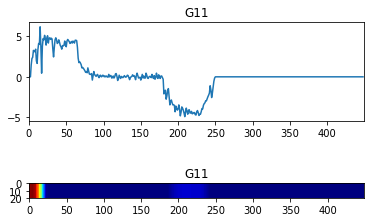

117
Test data number:  117


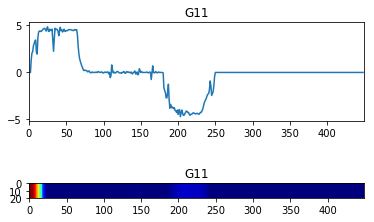

118
Test data number:  118


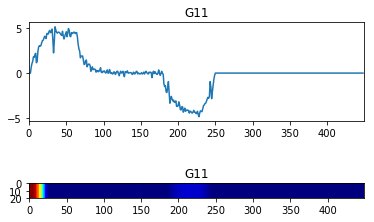

119
Test data number:  119


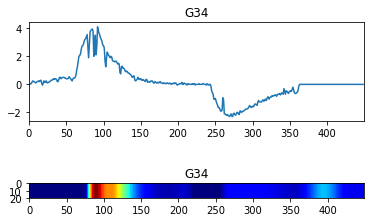

120
Test data number:  120


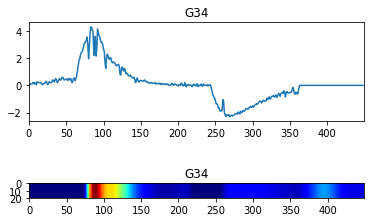

121
Test data number:  121


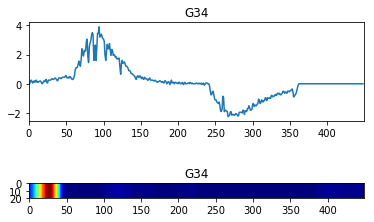

122
Test data number:  122


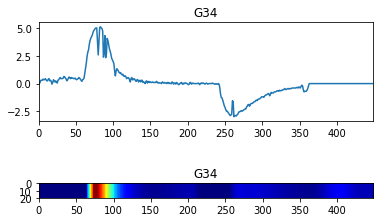

123
Test data number:  123


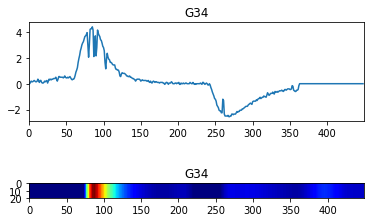

124
Test data number:  124


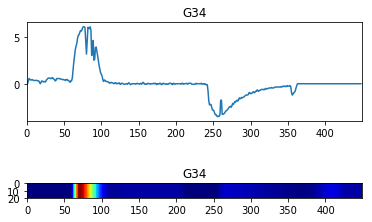

125
Test data number:  125


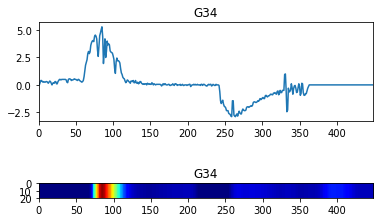

126
Test data number:  126


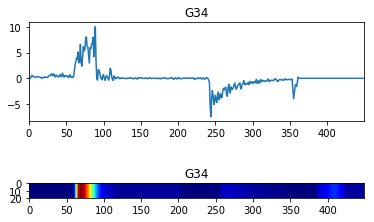

127
Test data number:  127


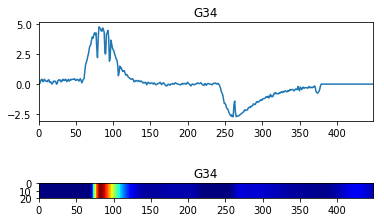

128
Test data number:  128


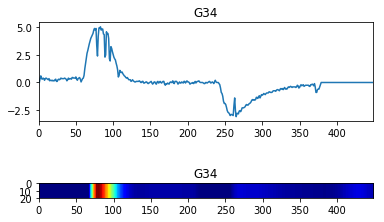

129
Test data number:  129


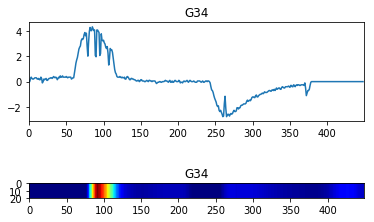

130
Test data number:  130


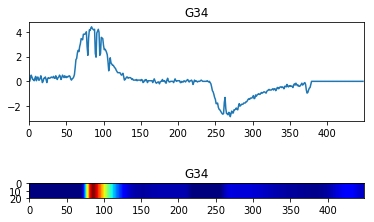

131
Test data number:  131


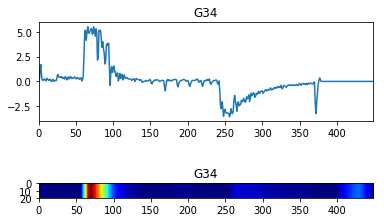

132
Test data number:  132


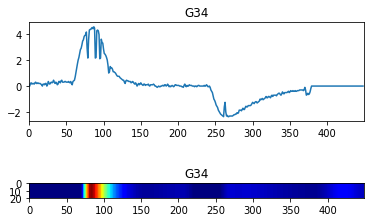

133
Test data number:  133


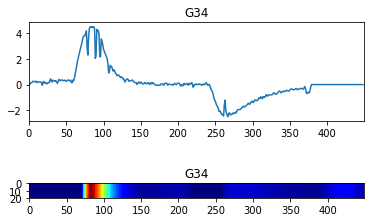

134
Test data number:  134


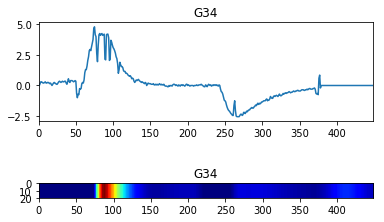

135
Test data number:  135


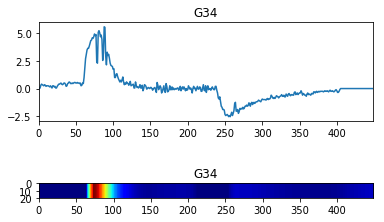

136
Test data number:  136


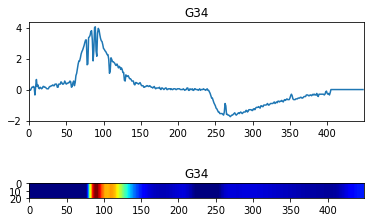

137
Test data number:  137


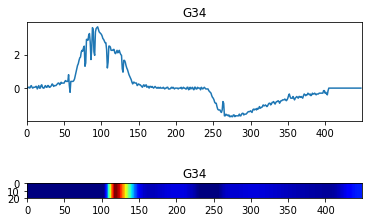

138
Test data number:  138


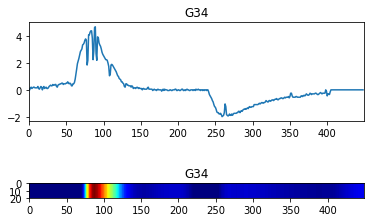

139
Test data number:  139


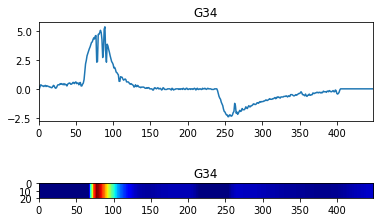

140
Test data number:  140


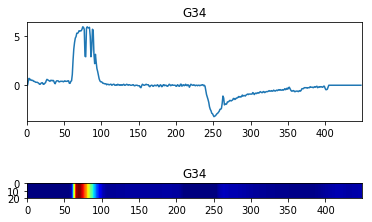

141
Test data number:  141


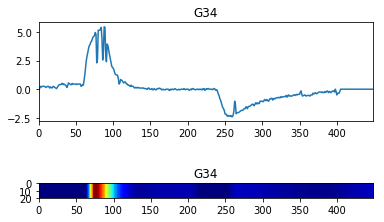

142
Test data number:  142


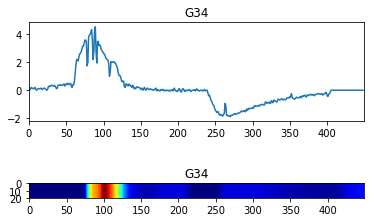

143
Test data number:  143


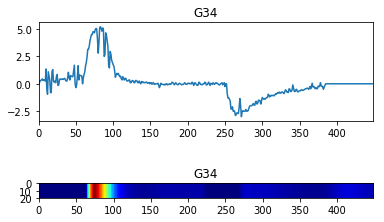

144
Test data number:  144


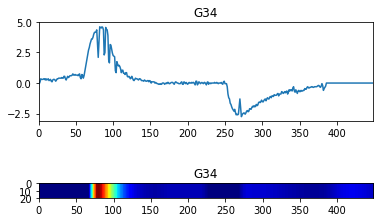

145
Test data number:  145


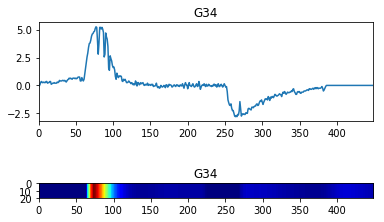

146
Test data number:  146


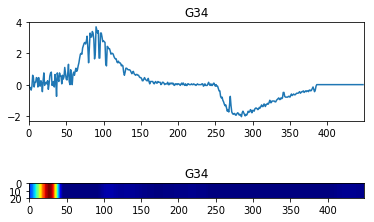

147
Test data number:  147


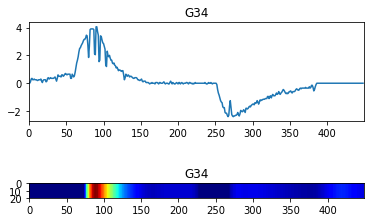

148
Test data number:  148


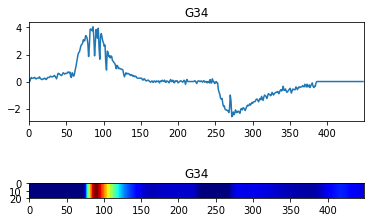

149
Test data number:  149


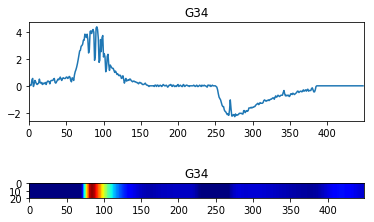

150
Test data number:  150


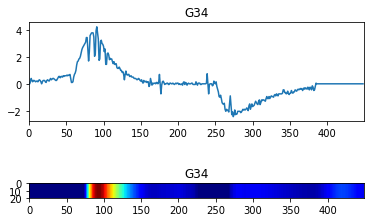

151
Test data number:  151


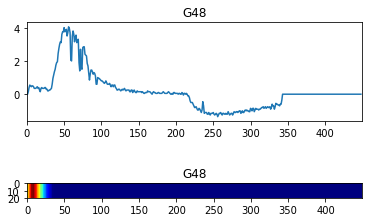

152
Test data number:  152


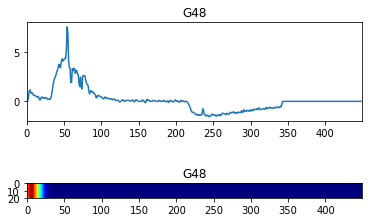

153
Test data number:  153


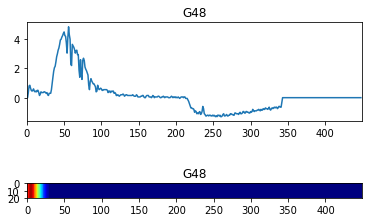

154
Test data number:  154


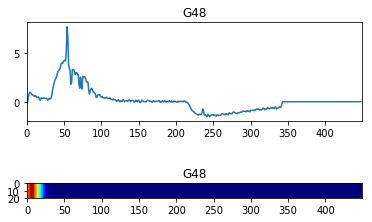

155
Test data number:  155


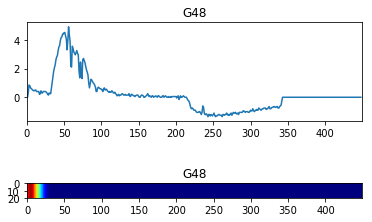

156
Test data number:  156


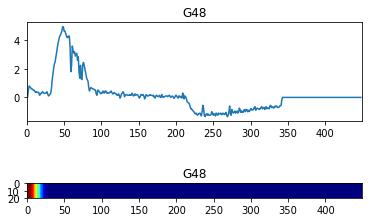

157
Test data number:  157


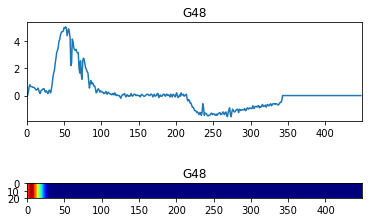

158
Test data number:  158


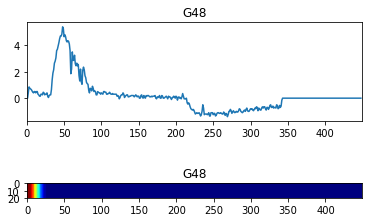

159
Test data number:  159


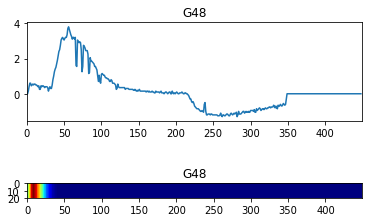

160
Test data number:  160


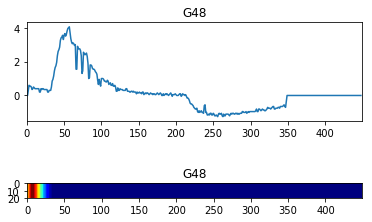

161
Test data number:  161


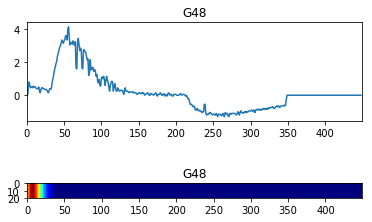

162
Test data number:  162


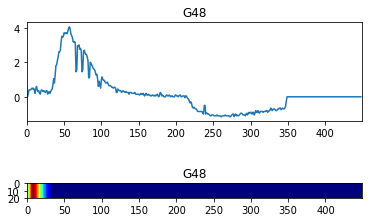

163
Test data number:  163


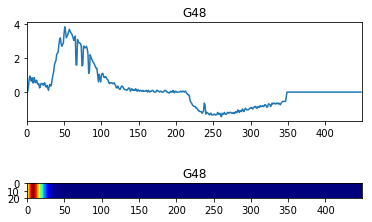

164
Test data number:  164


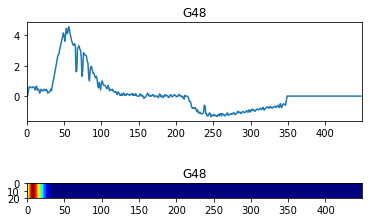

165
Test data number:  165


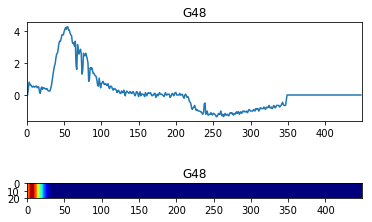

166
Test data number:  166


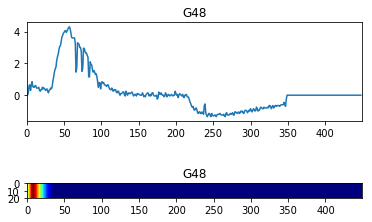

167
Test data number:  167


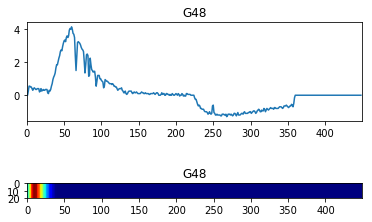

168
Test data number:  168


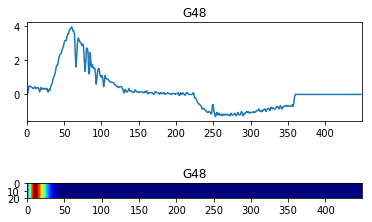

169
Test data number:  169


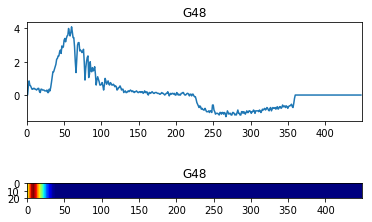

170
Test data number:  170


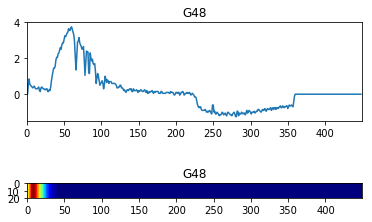

171
Test data number:  171


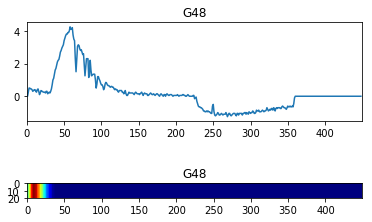

172
Test data number:  172


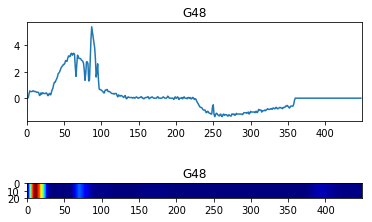

173
Test data number:  173


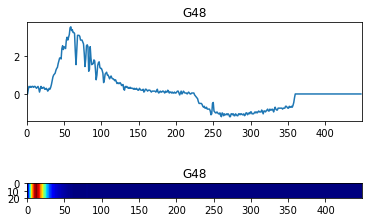

174
Test data number:  174


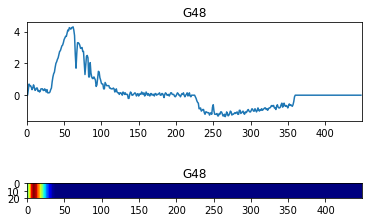

175
Test data number:  175


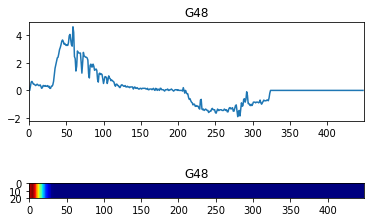

176
Test data number:  176


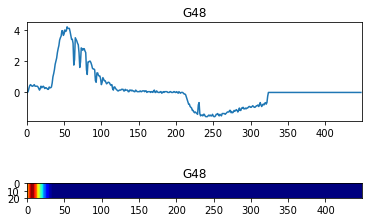

177
Test data number:  177


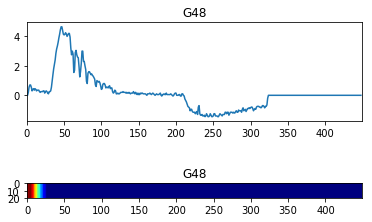

178
Test data number:  178


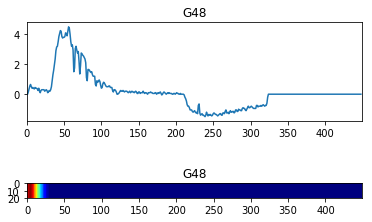

179
Test data number:  179


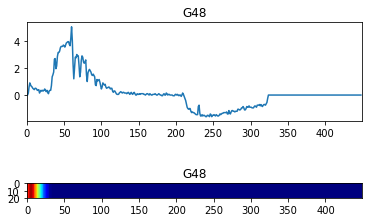

180
Test data number:  180


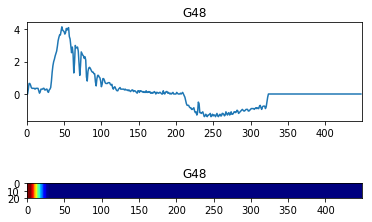

181
Test data number:  181


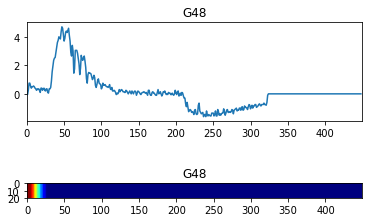

182
Test data number:  182


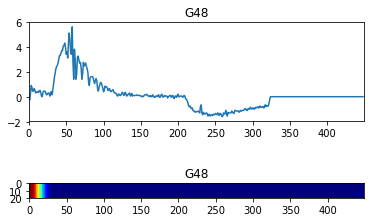

183
Test data number:  183


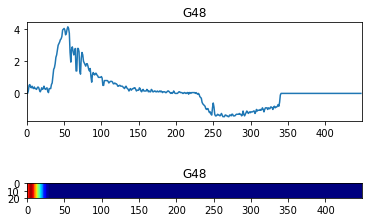

184
Test data number:  184


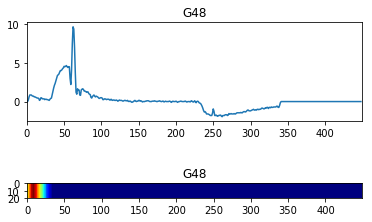

185
Test data number:  185


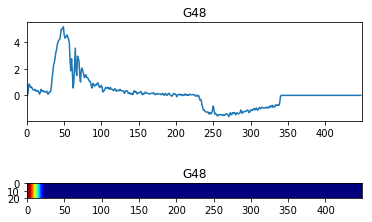

186
Test data number:  186


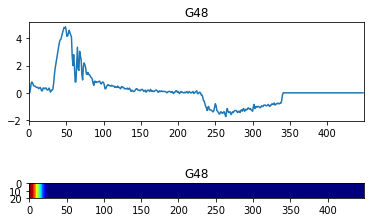

187
Test data number:  187


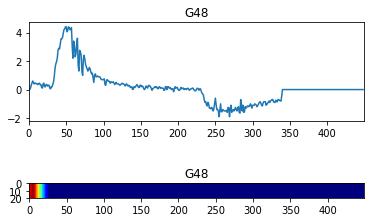

188
Test data number:  188


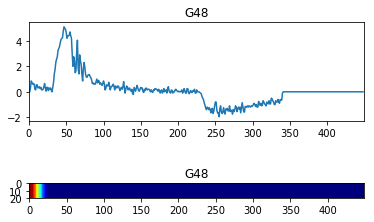

189
Test data number:  189


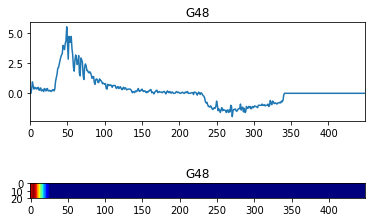

190
Test data number:  190


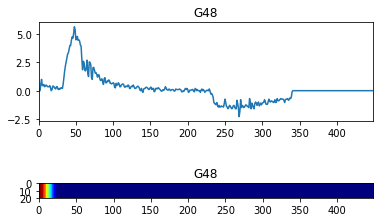

191
Test data number:  191


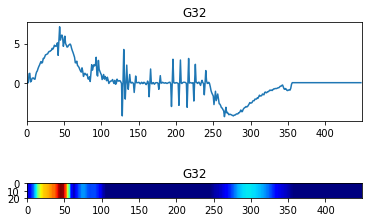

192
Test data number:  192


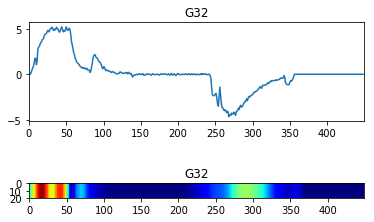

193
Test data number:  193


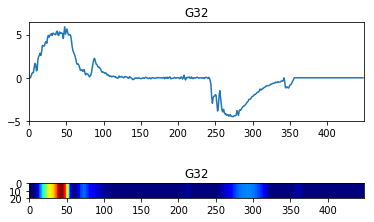

194
Test data number:  194


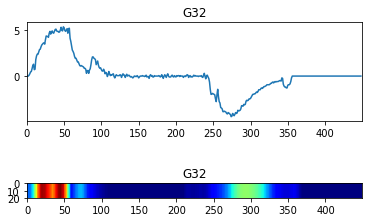

195
Test data number:  195


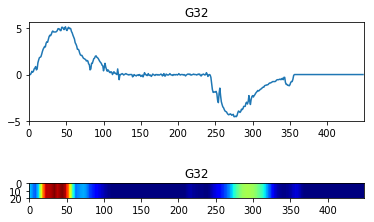

196
Test data number:  196


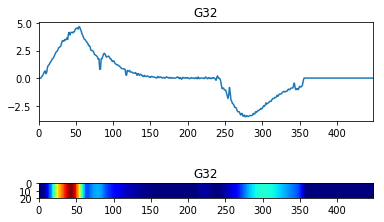

197
Test data number:  197


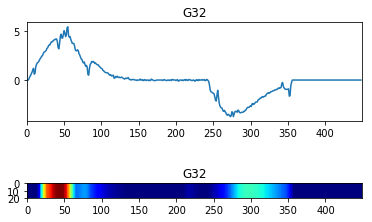

198
Test data number:  198


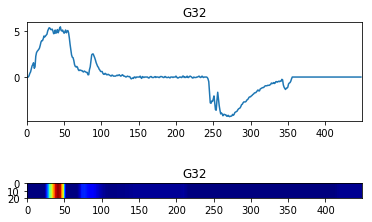

199
Test data number:  199


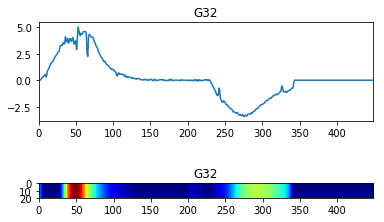

200
Test data number:  200


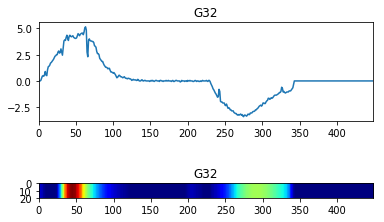

201
Test data number:  201


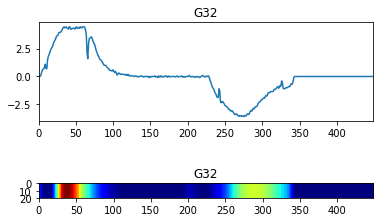

202
Test data number:  202


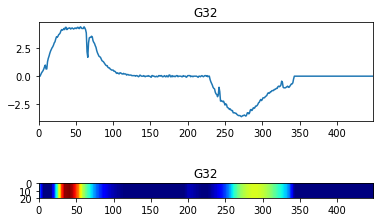

203
Test data number:  203


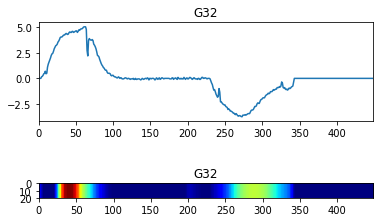

204
Test data number:  204


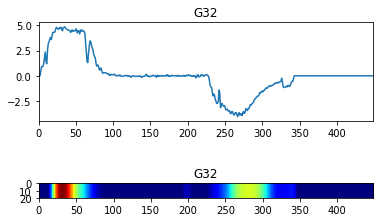

205
Test data number:  205


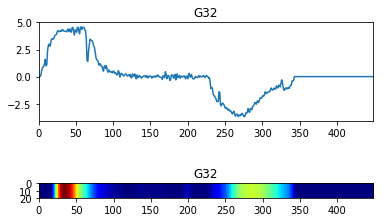

206
Test data number:  206


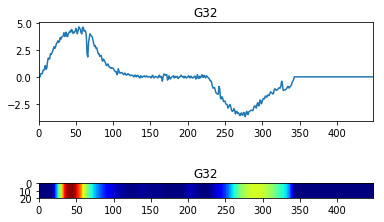

207
Test data number:  207


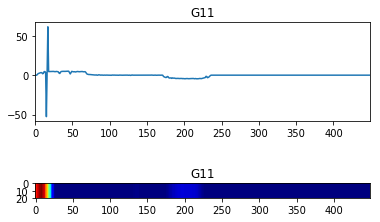

208
Test data number:  208


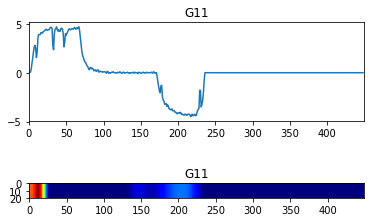

209
Test data number:  209


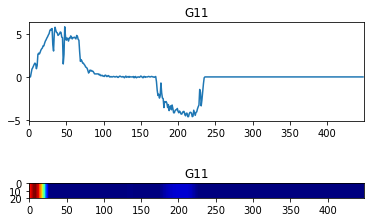

210
Test data number:  210


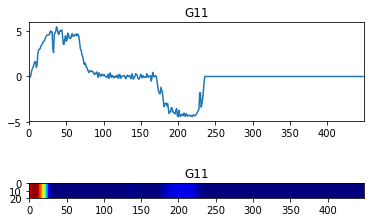

211
Test data number:  211


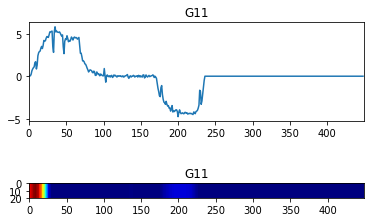

212
Test data number:  212


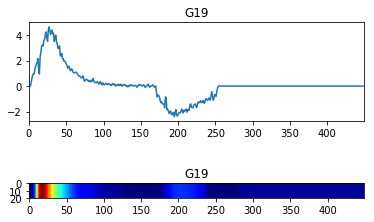

213
Test data number:  213


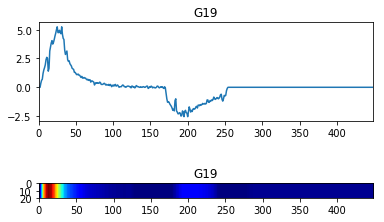

214
Test data number:  214


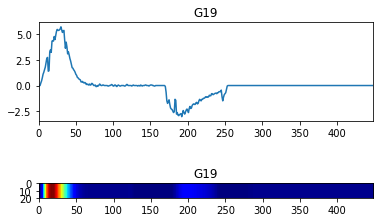

215
Test data number:  215


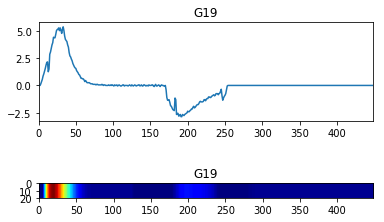

216
Test data number:  216


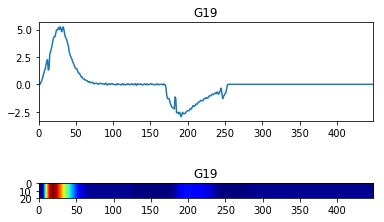

217
Test data number:  217


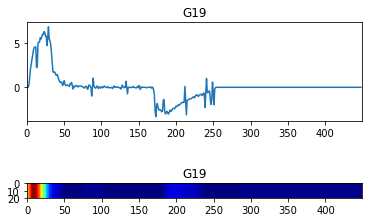

218
Test data number:  218


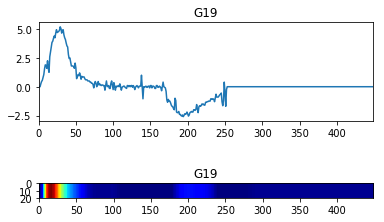

219
Test data number:  219


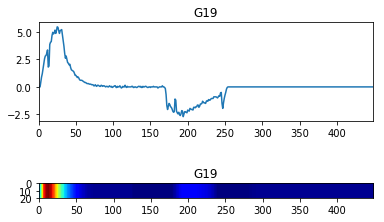

220
Test data number:  220


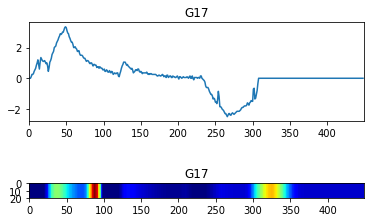

221
Test data number:  221


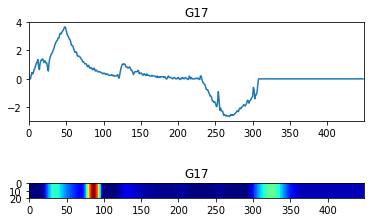

222
Test data number:  222


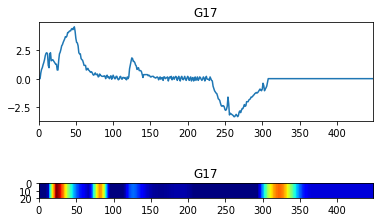

223
Test data number:  223


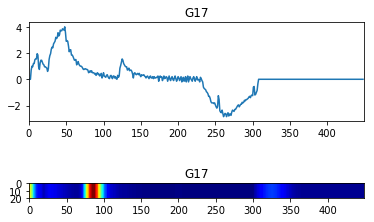

224
Test data number:  224


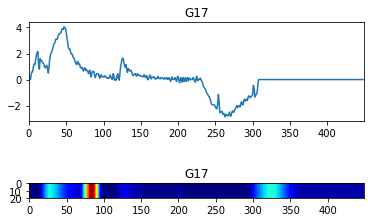

225
Test data number:  225


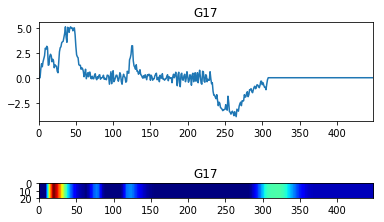

226
Test data number:  226


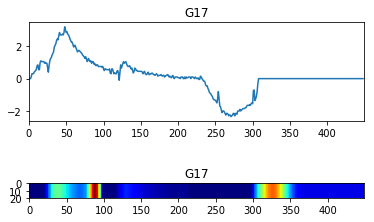

227
Test data number:  227


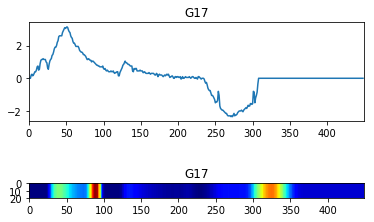

228
Test data number:  228


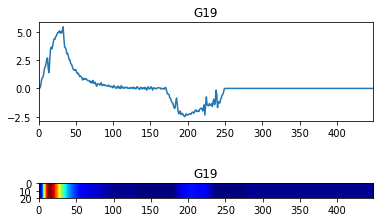

229
Test data number:  229


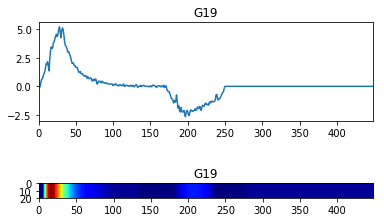

230
Test data number:  230


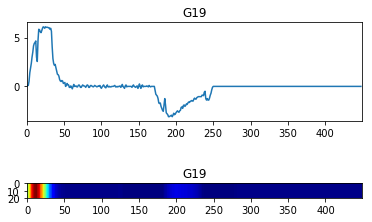

231
Test data number:  231


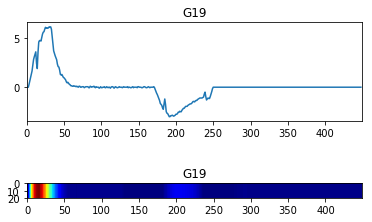

232
Test data number:  232


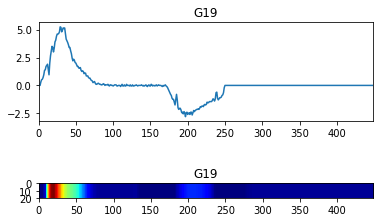

233
Test data number:  233


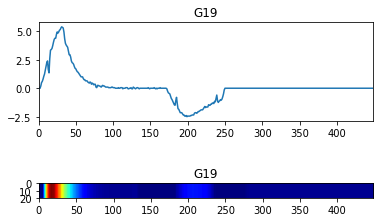

234
Test data number:  234


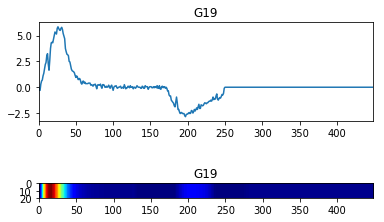

235
Test data number:  235


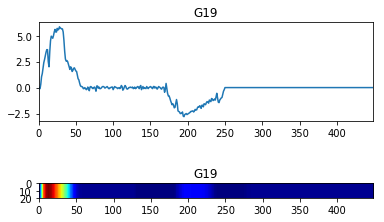

236
Test data number:  236


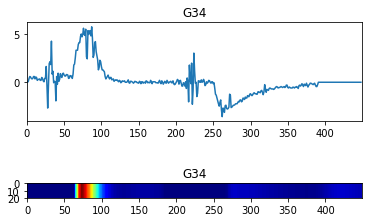

237
Test data number:  237


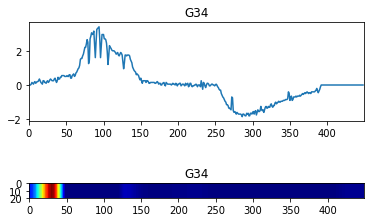

238
Test data number:  238


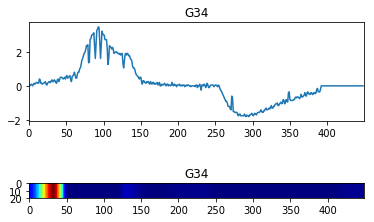

239
Test data number:  239


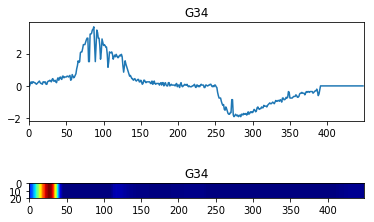

240
Test data number:  240


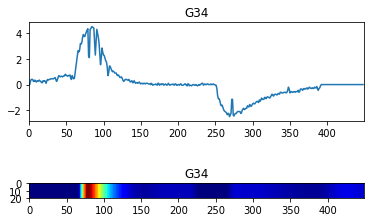

241
Test data number:  241


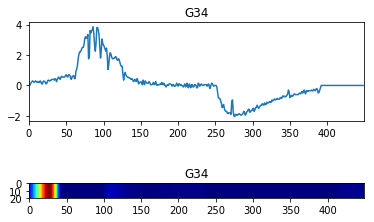

242
Test data number:  242


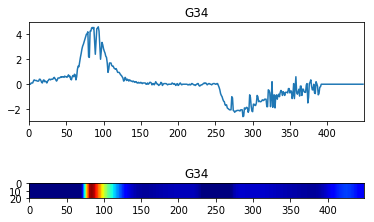

243
Test data number:  243


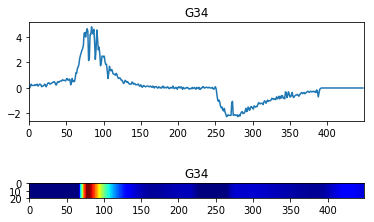

244
Test data number:  244


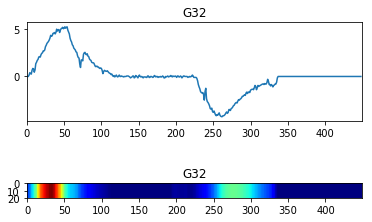

245
Test data number:  245


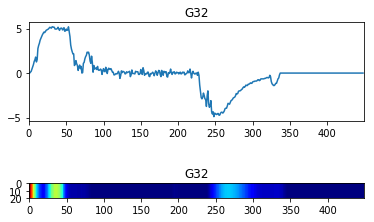

246
Test data number:  246


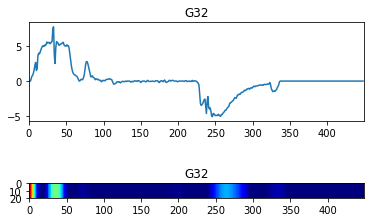

247
Test data number:  247


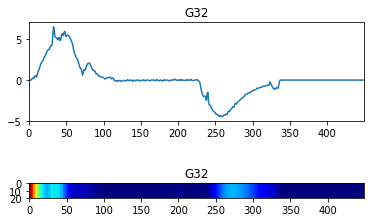

248
Test data number:  248


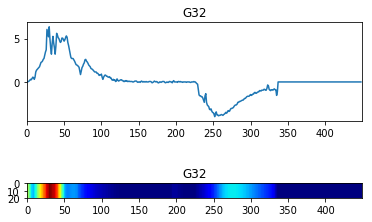

249
Test data number:  249


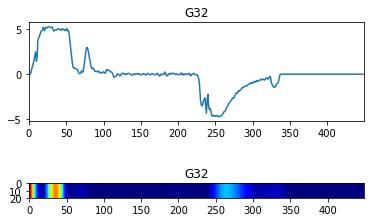

250
Test data number:  250


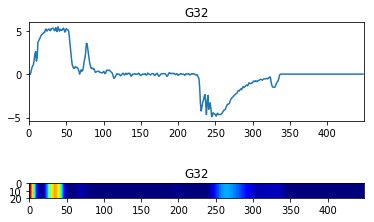

251
Test data number:  251


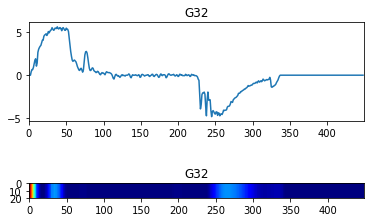

252
Test data number:  252


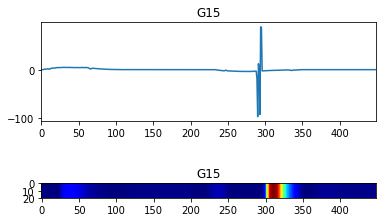

253
Test data number:  253


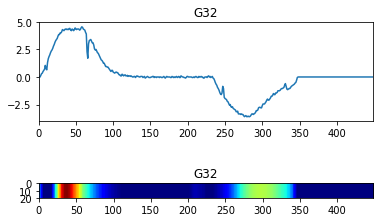

254
Test data number:  254


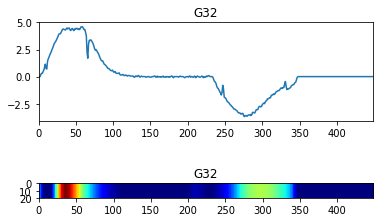

255
Test data number:  255


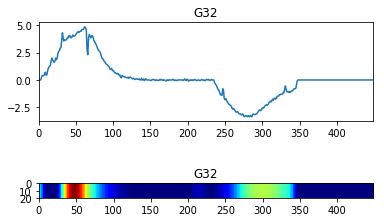

256
Test data number:  256


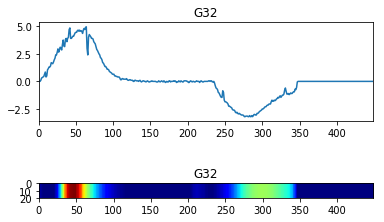

257
Test data number:  257


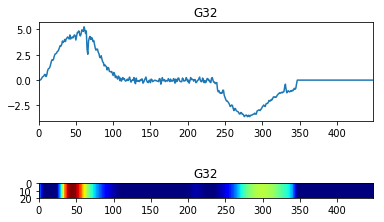

258
Test data number:  258


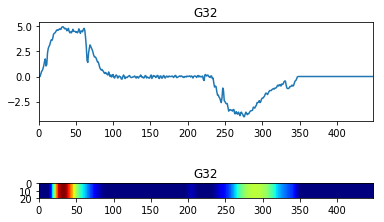

259
Test data number:  259


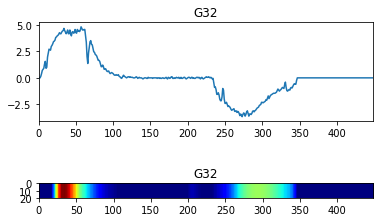

260
Test data number:  260


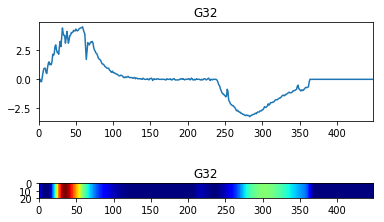

261
Test data number:  261


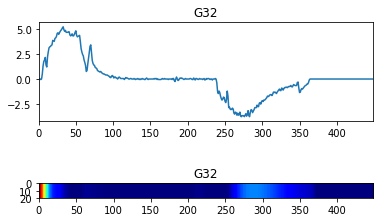

262
Test data number:  262


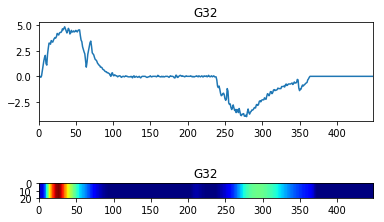

263
Test data number:  263


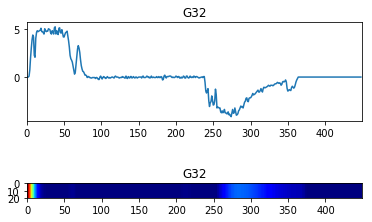

264
Test data number:  264


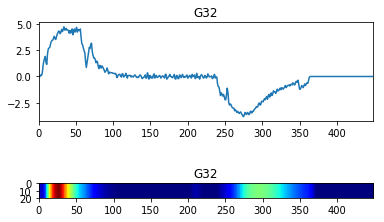

265
Test data number:  265


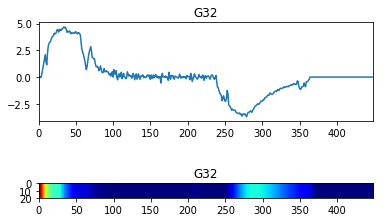

266
Test data number:  266


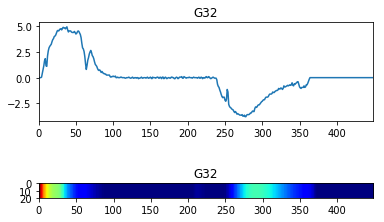

267
Test data number:  267


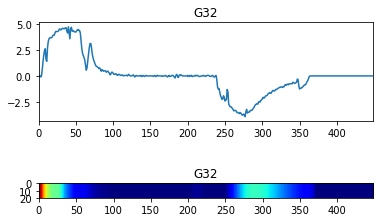

268
Test data number:  268


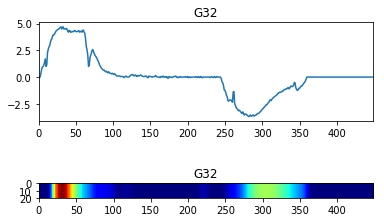

269
Test data number:  269


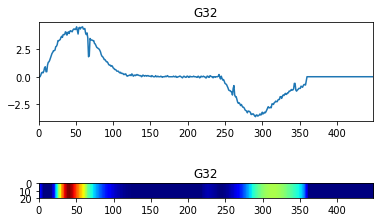

270
Test data number:  270


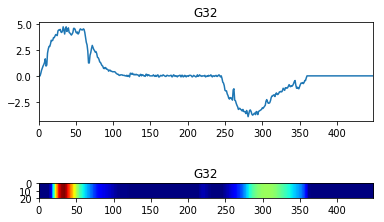

271
Test data number:  271


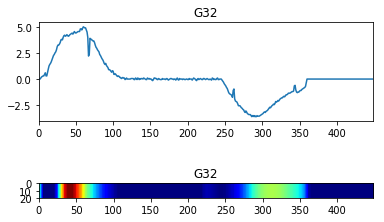

272
Test data number:  272


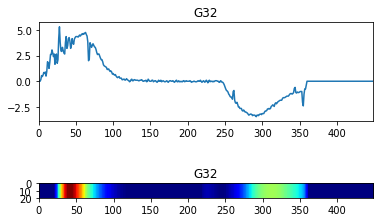

273
Test data number:  273


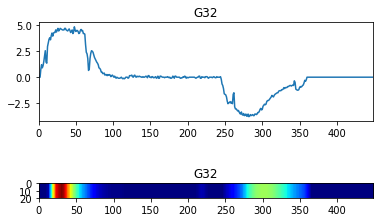

274
Test data number:  274


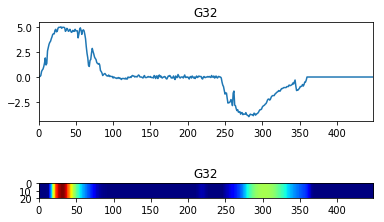

275
Test data number:  275


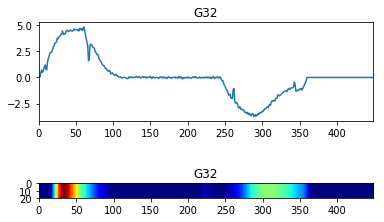

In [76]:
# 將所有測試數據都進行可視化分析，並輸出成圖檔儲存
cnt = 0  
for i in range(0,x_true_test.shape[0]):
  str_1 = str(i).zfill(3);
  print(str_1)  
  output_file = rootpath+'Result/VisualizationHeatMap_TrueTest/test_' + str_1 + '.jpg'

  print( "Test data number: ", i)
  test_num = i

  x = x_true_test.iloc[test_num,:]
  x = np.expand_dims(x, axis=0)

  # 取得曲線分類類別
  preds = model.predict(x)
  # pred_class = np.argmax(preds[0])
  L = np.argsort(-preds, axis=1)
  L = L.squeeze()
  # 將preds排序，L為其排序過的index，第1個為最大L[0]，第二個為第二大L[1]，依此類推
  pred_class = L[0]

  # 取得曲線分類名稱
  y_class_name = data_fin.Type.astype('category')
  y_class_name = y_class_name.dtypes.categories 
  y_class_name = y_class_name[pred_class]

  # 預測分類的輸出向量
  pred_output = model.output[:, pred_class]
  #print('pred_output.shape = ',pred_output.shape)

  # 最後一層 convolution layer 輸出的 feature map
  if cnt == 0:
    print(model.summary())
    print('Selected layer: ', model.layers[5].name)
    cnt = cnt+1

  last_conv_layer = model.get_layer(model.layers[5].name)

  # 求得分類的神經元對於最後一層 convolution layer 的梯度
  grads = K.gradients(pred_output, last_conv_layer.output)[0]

  # 求得針對每個 feature map 的梯度加總
  pooled_grads = K.sum(grads, axis=(0, 1))    

  # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
  # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
  # 的方式。
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
  # feature map
  # Sam: pooled_grads_value, shape = [2048,], 是W值
  # Sam: conv_layer_output_value, shape = [7,7,2048]

  pooled_grads_value, conv_layer_output_value = iterate([x])


  # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
  for i in range(pooled_grads_value.shape[0]):
    conv_layer_output_value[:, i] *= (pooled_grads_value[i]) 

  # 計算 feature map 的 channel-wise 加總
  heatmap = np.sum(conv_layer_output_value, axis=-1)

  # 擴充heatmap的維度，方便等等resize成為影像
  heatmap = np.expand_dims(heatmap, axis=0)

  # ReLU
  heatmap = np.maximum(heatmap, 0)

  # 正規化
  heatmap /= np.max(heatmap)      

  # 拉伸 heatmap
  heatmap = cv2.resize(heatmap, (x.shape[1], 20))

  heatmap = np.uint8(255 * heatmap)

  # 創建figure和axes
  fig, (ax1,ax2) = plt.subplots(2,1)

  # 繪製曲線圖
  ax1.plot(x[0,:])
  ax1.set_xlim(0, x.shape[1])
  ax1.set_title(y_class_name)

  # 繪製熱力圖
  ax2.imshow(heatmap, cmap='jet')
  ax2.set_title(y_class_name)
  plt.savefig(output_file)
  # files.download(output_file)

  plt.figure
  plt.show()
  plt.close('all')

###最後結果輸出

In [77]:
# 檔名重複的index
du_index = data_test['FileName'].duplicated()

# 每個檔案的開頭與結尾index
tmp_index = data_test.index[~du_index].tolist()
file_index = []
file_name = []

for i in range(0,len(tmp_index)-1):
  file_index = file_index+[[tmp_index[i],tmp_index[i+1]]]
  file_name = file_name+[data_test['FileName'][tmp_index[i]]]
  
file_index = file_index+[[tmp_index[i+1],data_test.shape[0]]]
file_name = file_name+[data_test['FileName'][tmp_index[i+1]]]  
  
print(file_index)  
print(file_name)

[[0, 6], [6, 14], [14, 20], [20, 28], [28, 36], [36, 44], [44, 52], [52, 60], [60, 68], [68, 76], [76, 82], [82, 90], [90, 98], [98, 106], [106, 114], [114, 119], [119, 127], [127, 135], [135, 143], [143, 151], [151, 159], [159, 167], [167, 175], [175, 183], [183, 191], [191, 199], [199, 207], [207, 212], [212, 220], [220, 228], [228, 236], [236, 244], [244, 252], [252, 260], [260, 268], [268, 276]]
['5.txt', '9.txt', '7.txt', '30.txt', '31.txt', '32.txt', '34.txt', '8.txt', '33.txt', '3.txt', '4.txt', '6.txt', '36.txt', '35.txt', '19.txt', '2.txt', '21.txt', '22.txt', '20.txt', '23.txt', '28.txt', '29.txt', '27.txt', '26.txt', '25.txt', '18.txt', '16.txt', '1.txt', '12.txt', '10.txt', '11.txt', '24.txt', '17.txt', '15.txt', '14.txt', '13.txt']


In [0]:
# 統計每個檔案分類的結果
file_name_int = []
file_cat = []
file_with_diff_cat = []

for i in range(0,len(file_name)):
  
  # 轉換檔名成整數
  (name,ext) = os.path.splitext(file_name[i])
  file_name_int = file_name_int+[int(name)]
  
  # 統計分類結果
  tmp = data_test['Type'][list(range(file_index[i][0],file_index[i][1]))]
  tmp = tmp.astype('category')
  cat_tmp = tmp.value_counts()
  cat_tmp = cat_tmp.index[0]
  file_cat = file_cat+[cat_tmp]
  
  if len(tmp.dtypes.categories)!=1:
    file_with_diff_cat = file_with_diff_cat+[i]

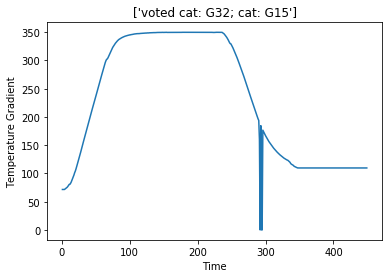

In [79]:
# 畫出檔案中分類不同的曲線

for i in file_with_diff_cat:
  tmp = data_test['Type'][list(range(file_index[i][0],file_index[i][1]))]
  tmp2 = data_test['FileName'][list(range(file_index[i][0],file_index[i][1]))]
  
  tmp = tmp.astype('category')
  cat_tmp = tmp.value_counts()
  cat_tmp1 = cat_tmp.index[0]
  
  for j in range(1,len(cat_tmp)):
    cat_tmp2 = cat_tmp.index[j]
    
    # 畫出檔案中分類不同的曲線
    
    plt.plot(data_test.iloc[tmp[tmp==cat_tmp2].index[0],3:data_test.shape[1]])
    plt.title(['voted cat: '+cat_tmp1+'; cat: '+cat_tmp2])
    plt.xlabel('Time')
    plt.ylabel('Temperature Gradient')        
    
    str_1 = str(tmp[tmp==cat_tmp2].index[0])
    output_file = rootpath+'Result/Test_Wrong_Cat/test_' + str_1 + '.jpg'
    plt.savefig(output_file)
    
    plt.figure
    plt.show()

In [0]:
# 輸出比賽格式結果

# 將完整的測驗數據DataFrame輸出
os.chdir(rootpath+'Result/Test_Prediction')
data_test.to_excel('TestResult_all.xlsx', index = None, header=True)

# 檔名排序
files_sort_ind = sorted(range(len(file_name_int)), key=lambda k: file_name_int[k])

# 結果DataFrame
data_test_res = pd.DataFrame(list(range(1,len(files_sort_ind)+1)))
data_test_res[1] = [file_cat[i] for i in files_sort_ind]
data_test_res.columns = ['測驗數據資料代號','分類結果']

# 輸出成excel的xlsx格式
os.chdir(rootpath+'Result/Test_Prediction')
data_test_res.to_excel('2_108059_TestResult.xlsx', index = None, header=True)